In [224]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.playlist import Playlist
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.stats import BootstrapEvaluator

import warnings
warnings.simplefilter('ignore')
load_dotenv();

# Loading the data

In [226]:
df = pd.read_pickle(os.path.join('datasets', "final_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 5890 songs


id                  title             artist  \
0  4RL77hMWUq35NYnPLXBpih            skinny love              birdy   
1  5PsjZ21f5tMPFf1sJpokm7              deathwish     red sun rising   
2  6vrUTGn5p8IrfTZ0J6sIVM                   iris  the goo goo dolls   
3  0Leo4GP0UKG4tUABm9JATe  don't dream it's over      crowded house   
4  0It6VJoMAare1zdV2wxqZq    undisclosed desires               muse   

                                       album_art_url  popularity explicit  \
0  https://i.scdn.co/image/ab67616d0000b2733661c0...        70.0        0   
1  https://i.scdn.co/image/ab67616d0000b273612f16...         NaN        0   
2  https://i.scdn.co/image/ab67616d0000b273d54c4b...        71.0        0   
3  https://i.scdn.co/image/ab67616d0000b27380ed24...         NaN        0   
4  https://i.scdn.co/image/ab67616d0000b273b6d456...        65.0        0   

   album_release_year  duration_ms  \
0                2011       201080   
1                2018       287946   
2                2007       289906   
3                2017       231377   
4                2009       235000   

                                              genres  \
0              ['neo mellow', 'uk pop', 'viral pop']   
1                ['modern hard rock', 'post-grunge']   
2  ['neo mellow', 'permanent wave', 'pop rock', '...   
3              ['australian rock', 'permanent wave']   
4  ['alternative rock', 'modern rock', 'permanent...   

                                              lyrics  ...  tfidf_90  tfidf_91  \
0  come skinni love last year pour littl salt nev...  ... -0.009893 -0.020482   
1  life fleet slow chill us wave feed bone right ...  ...  0.004470  0.000732   
2  id give forev touch caus know feel somehow you...  ... -0.075173  0.071167   
3  freedom within freedom without tri catch delug...  ...  0.007790 -0.009347   
4  know youv suffer dont want hide cold loveless ...  ...  0.018747 -0.015603   

   tfidf_92  tfidf_93  tfidf_94  tfidf_95  tfidf_96  tfidf_97  tfidf_98  \
0 -0.001781 -0.058974 -0.007119 -0.017290 -0.028022  0.031428  0.000788   
1  0.035927 -0.043734 -0.018628  0.058813  0.038440 -0.041469  0.038769   
2  0.040220 -0.036587 -0.011965 -0.017556 -0.010682  0.005375 -0.003637   
3 -0.009754  0.048401 -0.029192 -0.033700 -0.016872 -0.007183 -0.024591   
4 -0.030108  0.006722 -0.011523 -0.003344 -0.014128  0.022806  0.000023   

   tfidf_99  
0 -0.038012  
1 -0.012686  
2  0.030491  
3  0.025207  
4 -0.002402  

[5 rows x 178 columns]

In [227]:
df['popularity_imputed'] = 0
df.loc[df.popularity.isna(), 'popularity_imputed'] = 1
df.loc[df.popularity.isna(), 'popularity']  = df[~df.popularity.isna()].popularity.median()

In [228]:
df.popularity_imputed.value_counts()

0    5323
1     567
Name: popularity_imputed, dtype: int64

In [232]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]


audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

<Axes: >

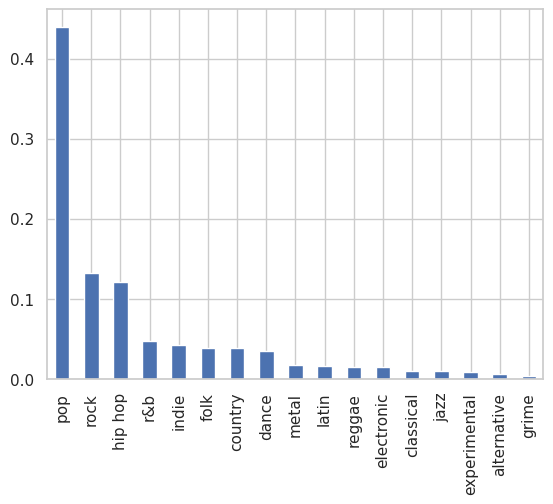

In [55]:
df.genre.value_counts(normalize=True).plot(kind='bar')

## 1. Correlation Heatmap
Purpose:
The correlation heatmap is used to visualize the pairwise correlation between multiple numerical features in your dataset. It helps identify which features are highly correlated with each other.

How It Works:

Correlation measures the strength of a linear relationship between two variables. The most common method is Pearson correlation, where values range from -1 to 1:
1 means perfect positive correlation.
-1 means perfect negative correlation.
0 means no correlation.
In your analysis, you calculated the correlation matrix, which shows correlations for all features, and then filtered for correlations above a threshold (e.g., 0.5).
The heatmap is a graphical representation where color intensity reflects the strength of the correlation.
Conclusion:
From your correlation heatmap, you likely identified pairs or groups of features that are strongly correlated (for example, duration_ms and syllable_count). These insights can inform feature selection or suggest which features might introduce redundancy into models. It also helps to reduce multicollinearity when building models.



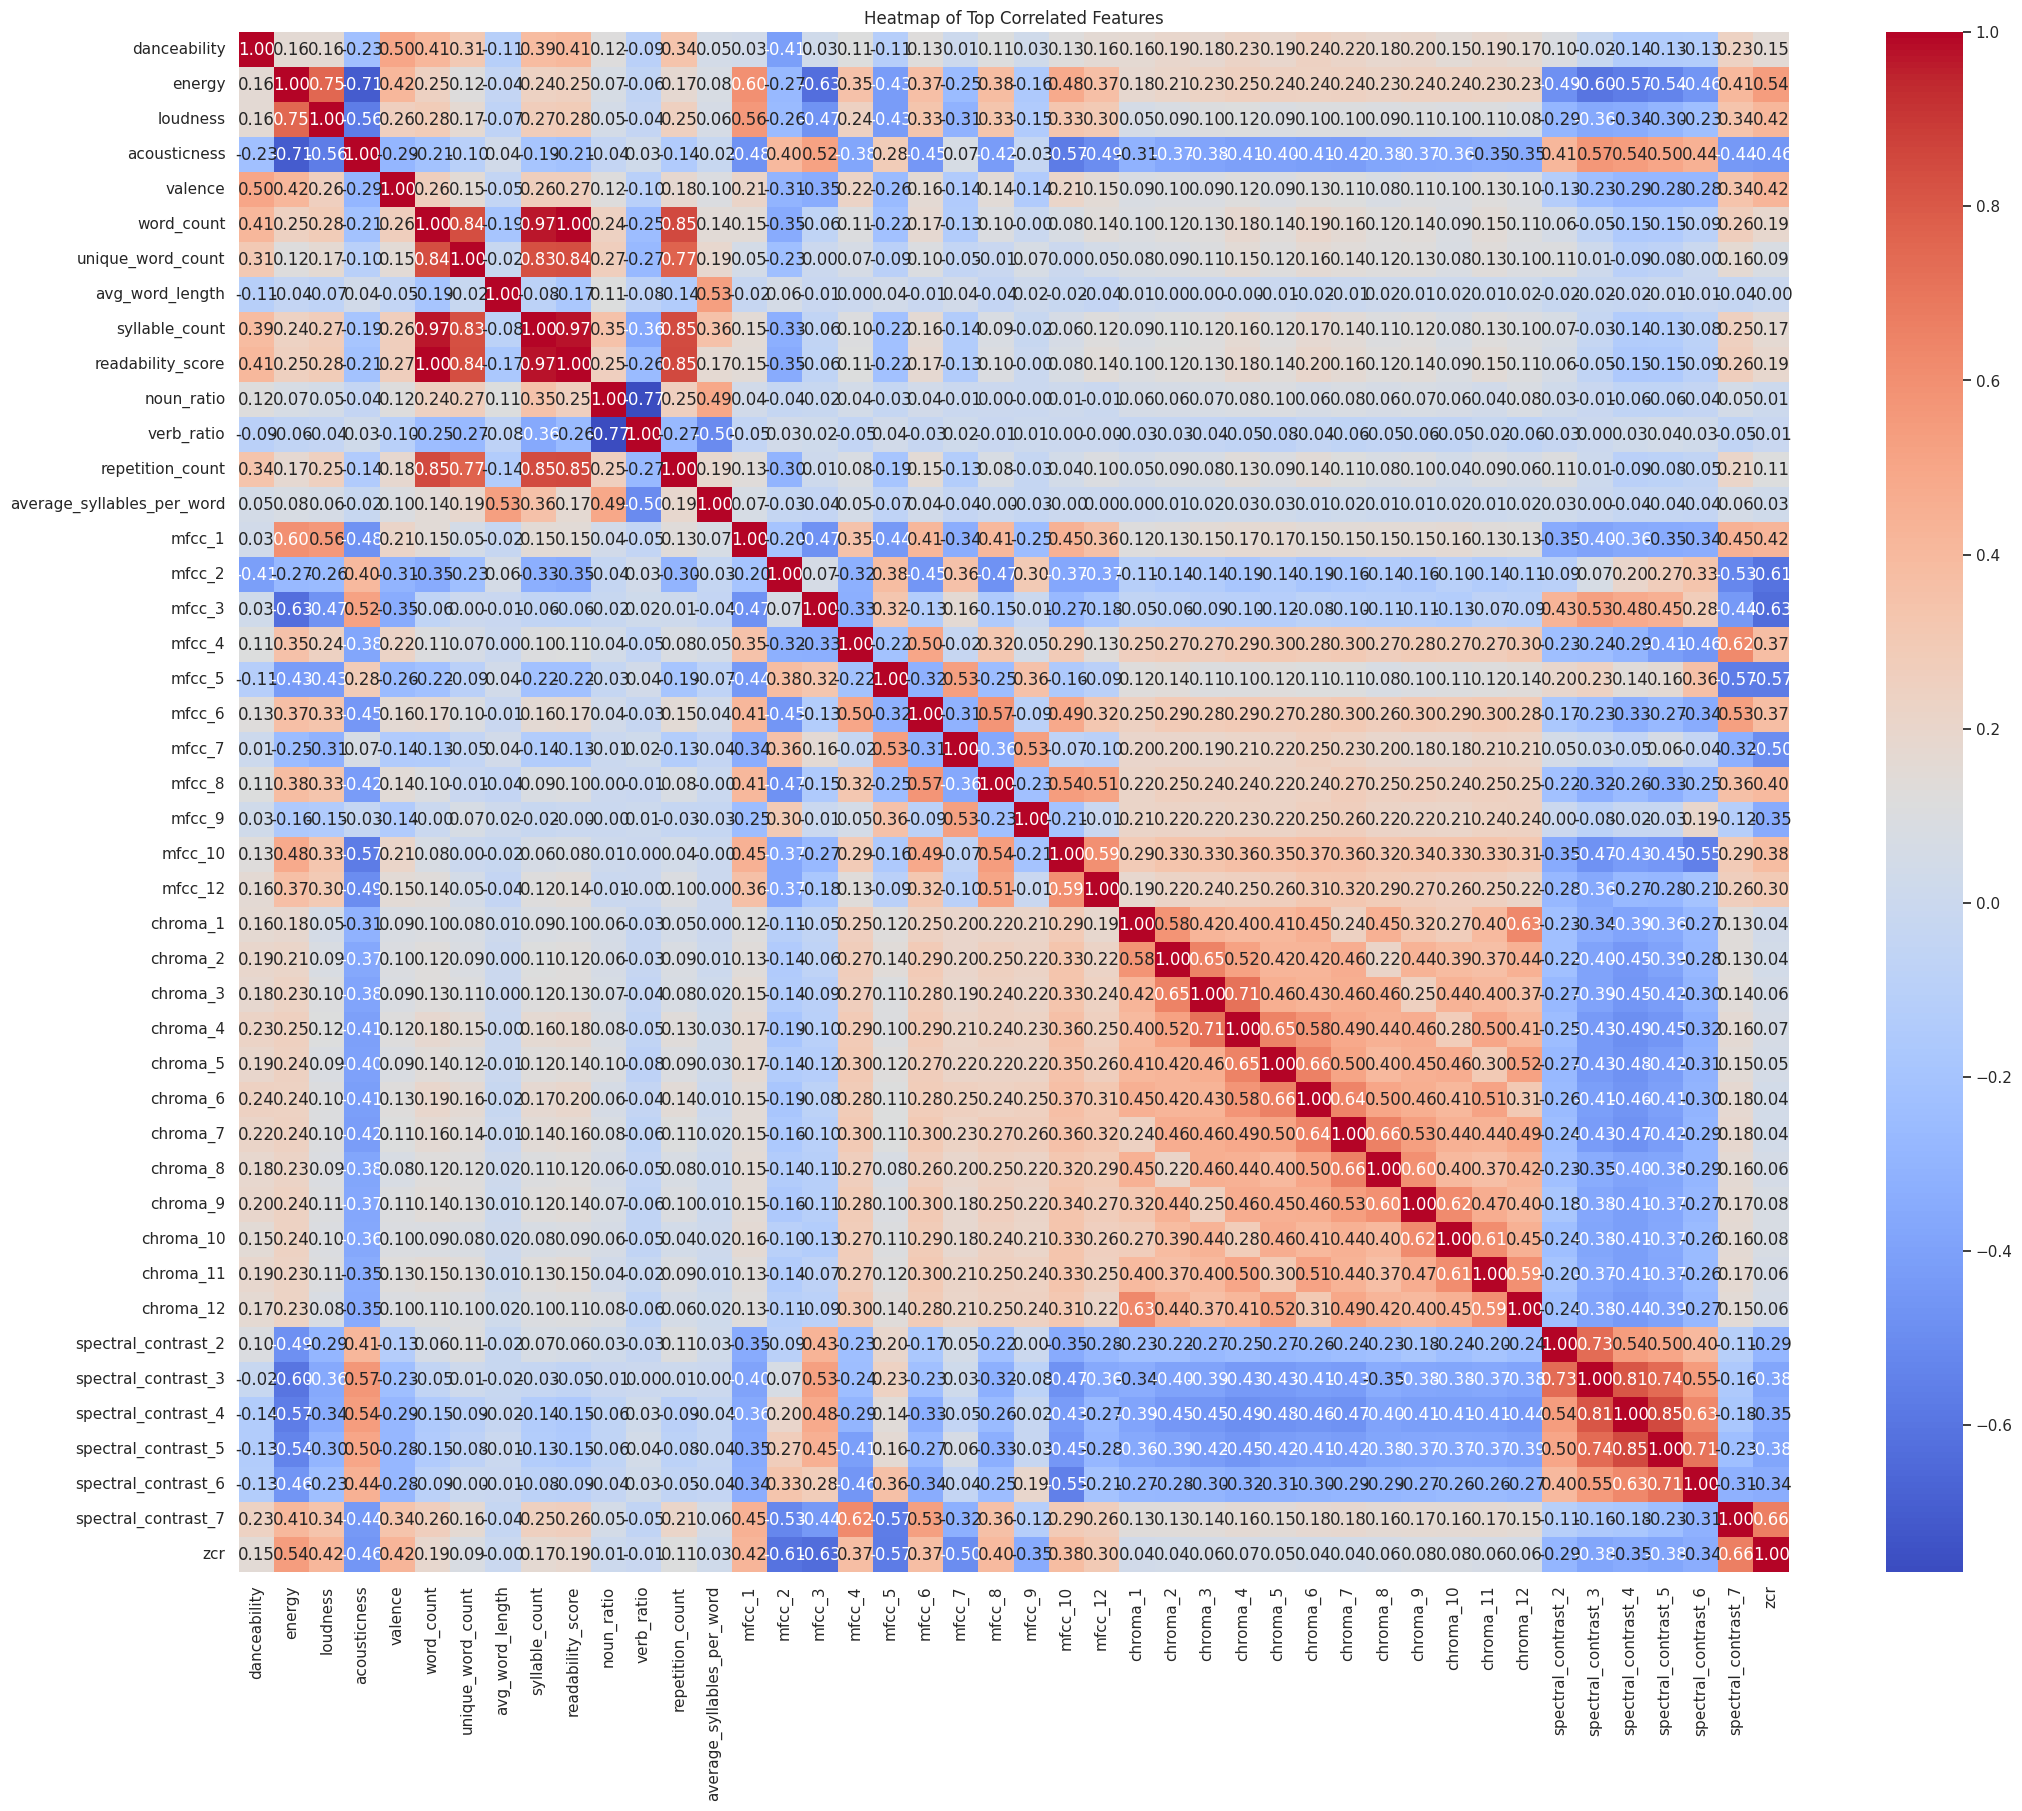

In [56]:
num_df = df[spotify_features + lyrics_features + audio_extracted_features].select_dtypes(include=[np.number]).dropna()

corr_matrix = num_df.corr()

high_corr_features = corr_matrix[corr_matrix.abs() > 0.5].stack().reset_index()
high_corr_features = high_corr_features[high_corr_features['level_0'] != high_corr_features['level_1']]

top_corr_features = pd.unique(high_corr_features[['level_0', 'level_1']].values.ravel('K'))

plt.figure(figsize=(25, 20))
sns.heatmap(num_df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Top Correlated Features', fontsize=12)
plt.show()

## 2. Hierarchical Clustering (Dendrogram)
Purpose:
Hierarchical clustering groups similar features based on their pairwise correlations, visualized using a dendrogram. This technique helps in clustering features into groups that are highly correlated, reducing dimensionality or simplifying feature analysis.

How It Works:

The dendrogram is built using agglomerative clustering, where each feature starts in its own cluster, and the most similar clusters are merged at each step. This continues until all features are grouped into a single cluster.
The Ward linkage method was used, which minimizes the variance within clusters.
The vertical axis represents the distance (or dissimilarity) between clusters. The longer the vertical lines between two clusters, the more dissimilar they are.
Conclusion:
Hierarchical clustering allowed you to identify clusters of features that are strongly correlated. You can decide to keep one feature from each cluster to avoid redundancy. For example, acousticness and instrumentalness might fall into the same cluster due to their similarity.

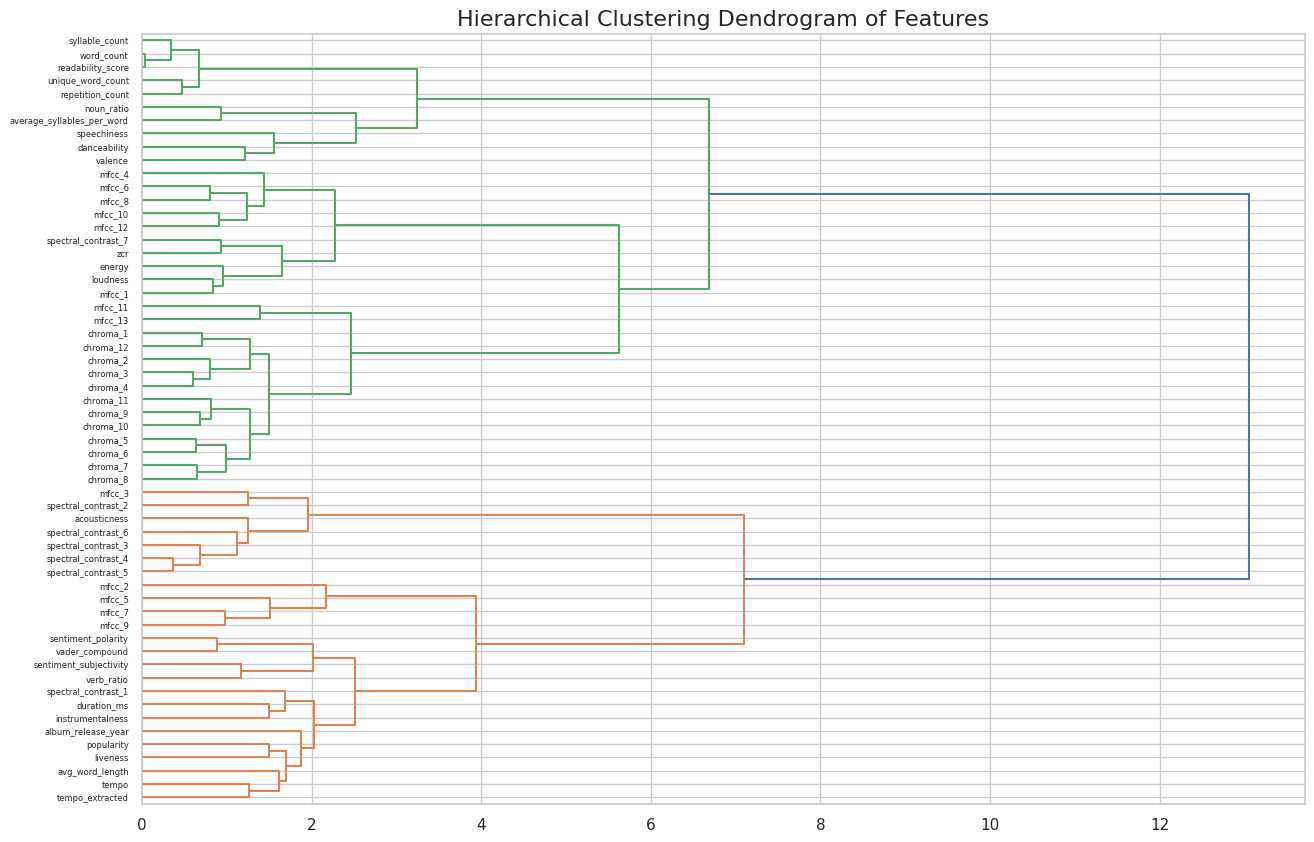

In [57]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

corr_matrix = num_df.corr()

linked = linkage(corr_matrix, 'ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, labels=corr_matrix.columns, orientation='right', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram of Features', fontsize=16)
plt.show()

## 3. Pairplot for Highly Correlated Features
Purpose:
The pairplot is used to visualize the relationships between pairs of highly correlated features, enabling you to see patterns or potential relationships.

How It Works:

After identifying features with a high correlation (above 0.7 in your case), the pairplot generates scatter plots for each pair of features.
It also shows the distribution of each feature along the diagonal of the plot.
This technique highlights relationships that might not be immediately obvious in raw numerical data.
Conclusion:
The pairplot allows you to confirm whether highly correlated features exhibit a strong linear relationship or if they follow a more complex pattern. For example, features like energy and loudness might show a positive linear relationship in the pairplot.

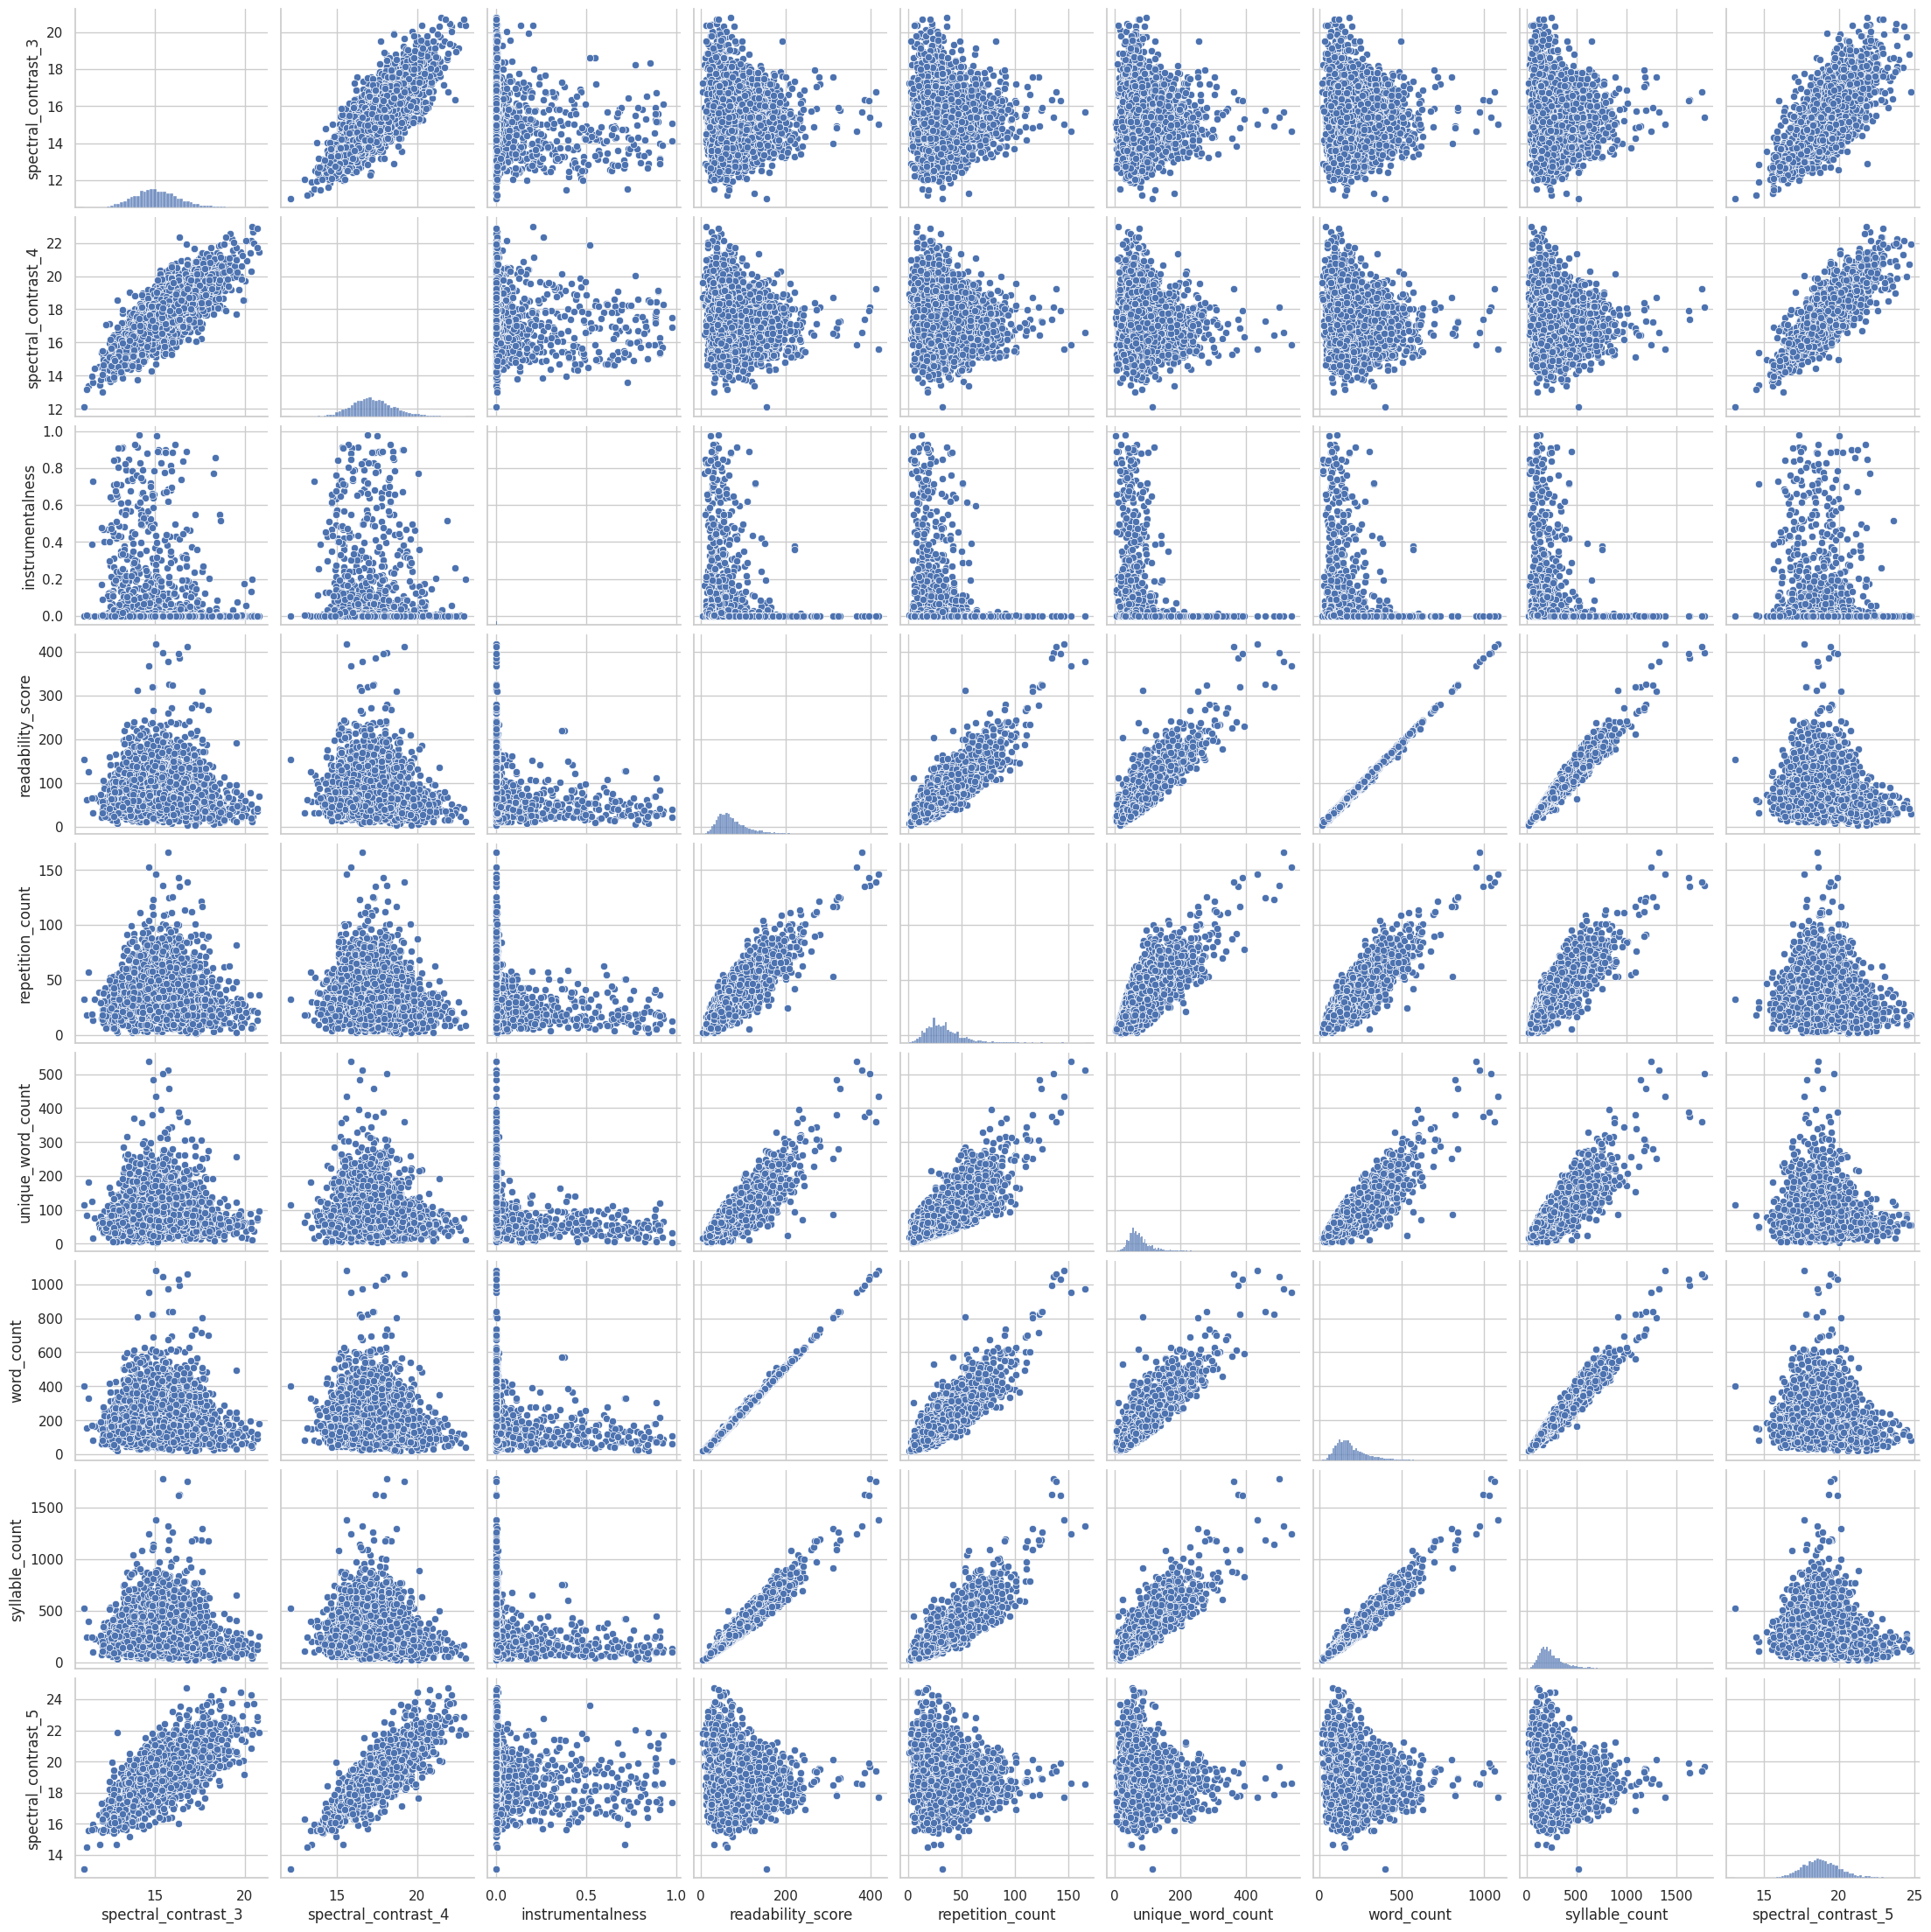

In [58]:
corr_matrix = num_df.corr().abs()
high_corr_var = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
high_corr_var = high_corr_var[high_corr_var > 0.8]

top_corr_pairs = high_corr_var.index.tolist()
top_features = list(set([feature for pair in top_corr_pairs for feature in pair]))

sns.pairplot(num_df[top_features])
plt.show()

## 4. Network Graph of Highly Correlated Features
Purpose:
This method visualizes the relationships between highly correlated features as a network graph. It helps in understanding how features are interconnected.

How It Works:

You constructed a graph where each node represents a feature, and edges between nodes represent strong correlations (above a threshold, e.g., 0.7).
The spring layout was used to visualize the network, where highly connected nodes are pulled together, and less connected nodes are pushed apart.
Conclusion:
The network graph gives a visual summary of how features relate to each other, with clusters of nodes indicating groups of correlated features. This helps identify which features tend to co-occur in specific types of songs, such as danceability and energy forming one group, and acousticness and instrumentalness forming another.

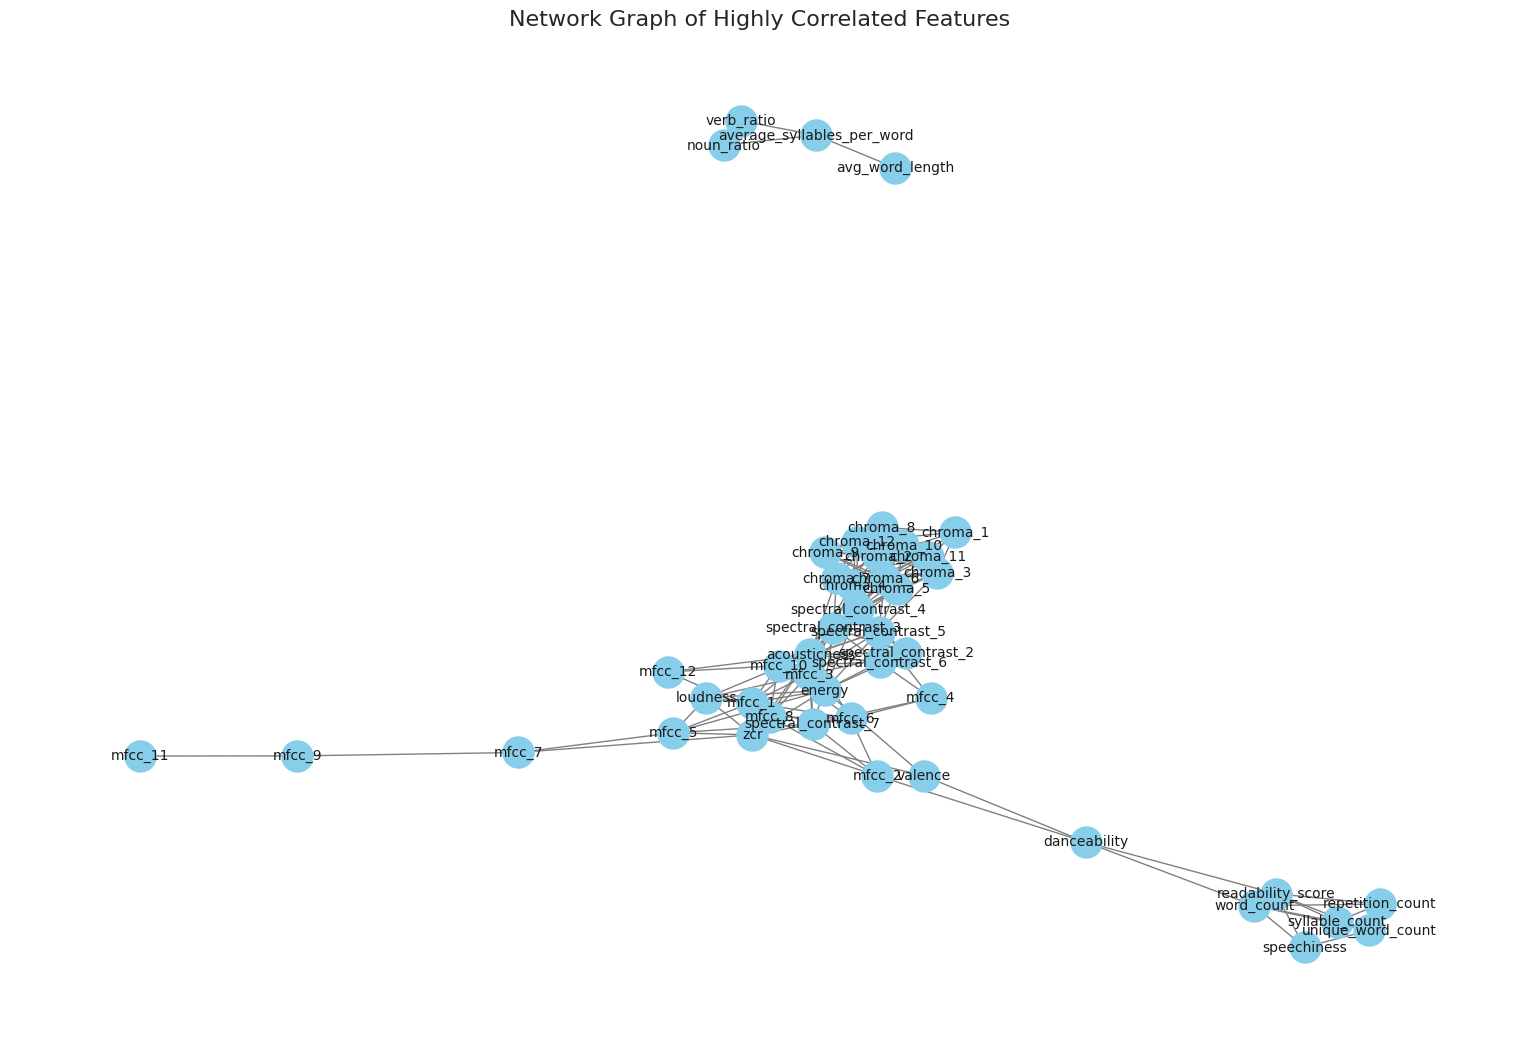

In [61]:
import networkx as nx

corr_matrix = num_df.corr().abs()
high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlation'] > 0.4) & (high_corr_pairs['Feature1'] != high_corr_pairs['Feature2'])]

G = nx.from_pandas_edgelist(high_corr_pairs, 'Feature1', 'Feature2', edge_attr='Correlation')

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10)
plt.title('Network Graph of Highly Correlated Features', fontsize=16)
plt.show()


## 5. t-SNE (t-Distributed Stochastic Neighbor Embedding)
Purpose:
t-SNE is used to visualize high-dimensional data in a 2D or 3D space while preserving local structure (similarities between points). It is particularly useful for visualizing clusters in data.

How It Works:

t-SNE reduces the dimensionality of data by modeling pairwise similarities between points in high-dimensional space and attempts to preserve these similarities in the low-dimensional projection.
t-SNE uses a probability distribution to calculate the similarity between points, with closer points in the original space being more likely to remain close in the reduced space.
It is useful for visualizing non-linear relationships in data, unlike PCA, which focuses on linear variance.
Conclusion:
In your t-SNE plot, you likely saw clusters of points corresponding to groups of songs that are similar in terms of their features. Well-separated clusters suggest that the songs in different groups are quite distinct in terms of musical characteristics or lyrics.



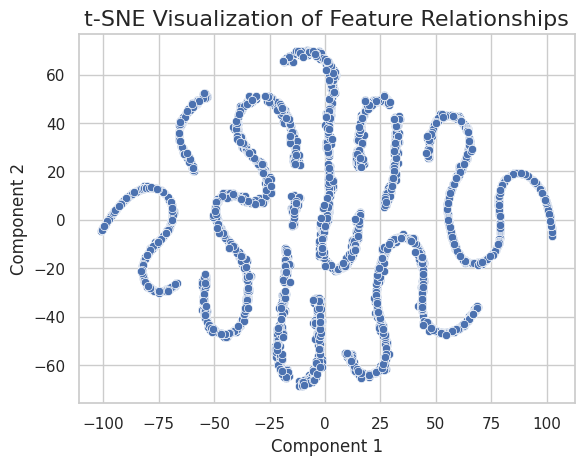

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(num_df)

tsne_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])
sns.scatterplot(x='Component 1', y='Component 2', data=tsne_df)
plt.title('t-SNE Visualization of Feature Relationships', fontsize=16)
plt.show()

# Mean song popualrity per genre

<Axes: xlabel='popularity', ylabel='Count'>

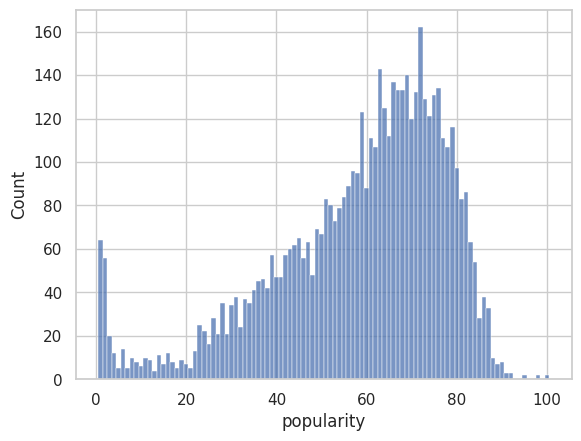

In [67]:
sns.histplot(df[df.popularity_imputed == 0].popularity, discrete=True)

<Axes: xlabel='genre'>

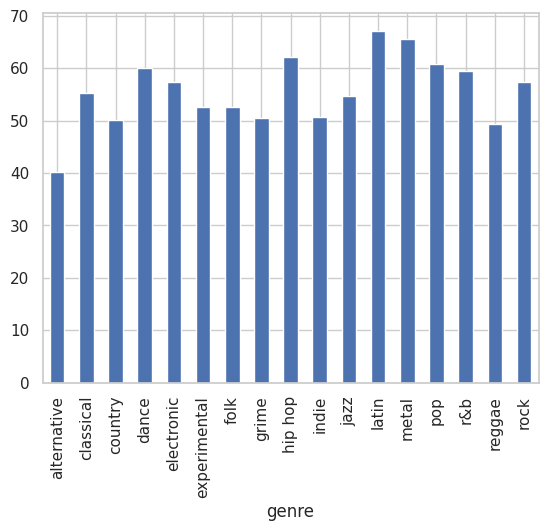

In [70]:
df.groupby("genre").popularity.mean().plot(kind='bar')

# Percent of explicit songs per year

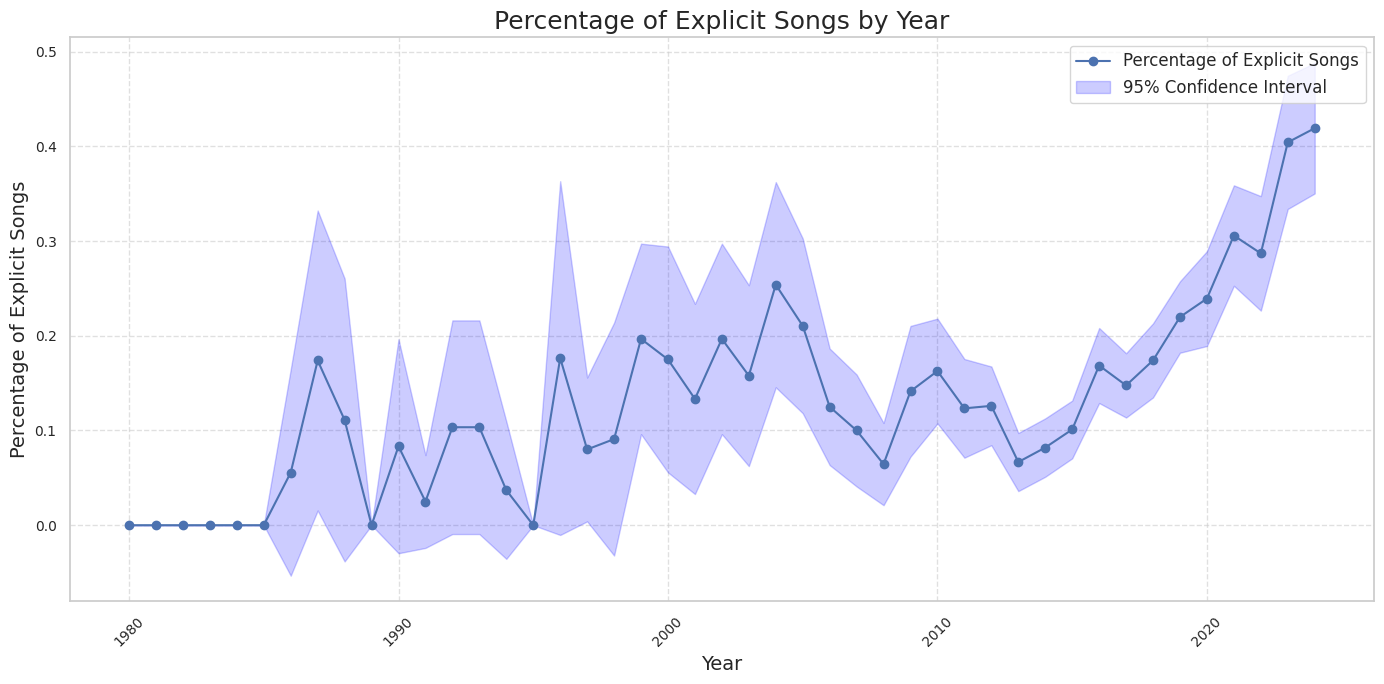

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure that tmp.explicit is numeric (0 or 1)
tmp = df[['explicit', 'album_release_year']].copy()
tmp['explicit_int'] = tmp['explicit'].astype(int)

# Group data by year and calculate the mean, sample size, and standard deviation
summary = (
    tmp.groupby('album_release_year')['explicit_int']
    .agg(['mean', 'count', 'std'])
    .reset_index()
    .rename(columns={'mean': 'percentage_explicit', 'count': 'sample_size', 'std': 'std_dev'})
)

# Calculate confidence intervals (assuming a normal distribution)
summary['ci'] = 1.96 * (summary['std_dev'] / np.sqrt(summary['sample_size']))

# Filter years to start from 1980
summary = summary[summary['album_release_year'] >= 1980]

# Plotting the lineplot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(
    summary['album_release_year'], 
    summary['percentage_explicit'], 
    marker='o', 
    label='Percentage of Explicit Songs'
)

# Add shaded confidence intervals
plt.fill_between(
    summary['album_release_year'], 
    summary['percentage_explicit'] - summary['ci'], 
    summary['percentage_explicit'] + summary['ci'], 
    color='blue', 
    alpha=0.2, 
    label='95% Confidence Interval'
)

# Add titles and labels
plt.title('Percentage of Explicit Songs by Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Explicit Songs', fontsize=14)

# Customize ticks and grid
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()

# Popularity vs. explicit content

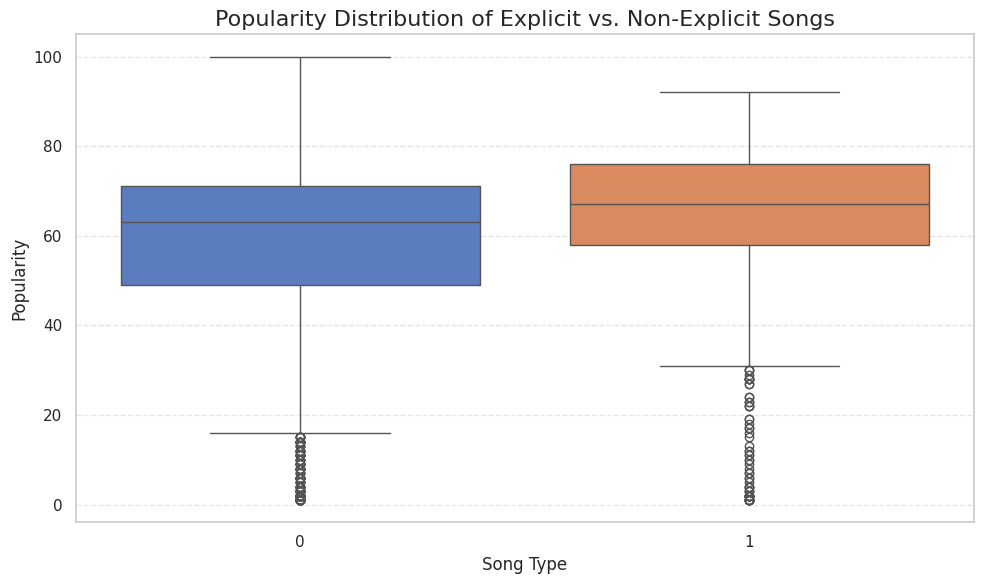

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


explicit_vs_popularity = tmp_df[['explicit', 'popularity']].copy()
explicit_vs_popularity['explicit_label'] = explicit_vs_popularity['explicit']

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='explicit_label', 
    y='popularity', 
    data=explicit_vs_popularity, 
    palette='muted'
)

plt.title('Popularity Distribution of Explicit vs. Non-Explicit Songs', fontsize=16)
plt.xlabel('Song Type', fontsize=12)
plt.ylabel('Popularity', fontsize=12)

plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5, axis='y')
plt.show()

In [189]:
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

def winsorize_series(series, lower_percentile=0.025, upper_percentile=0.975):
    lower_limit = np.percentile(series, lower_percentile * 100)
    upper_limit = np.percentile(series, upper_percentile * 100)
    return np.clip(series, lower_limit, upper_limit)

tmp_df['popularity_winsorized'] = winsorize_series(tmp_df['popularity'])

explicit_popularity = tmp_df.loc[tmp_df['explicit'] == '1', 'popularity_winsorized']
non_explicit_popularity = tmp_df.loc[tmp_df['explicit'] == '0', 'popularity_winsorized']

t_stat, t_pval = ttest_ind(explicit_popularity, non_explicit_popularity, equal_var=False)

u_stat, u_pval = mannwhitneyu(explicit_popularity, non_explicit_popularity, alternative='two-sided')

print(f"T-Test Results: t-statistic = {t_stat:.3f}, p-value = {t_pval:.3e}")
print(f"Mann-Whitney U Test Results: U-statistic = {u_stat:.3f}, p-value = {u_pval:.3e}")

T-Test Results: t-statistic = 8.482, p-value = 5.596e-17
Mann-Whitney U Test Results: U-statistic = 2891255.500, p-value = 1.198e-25


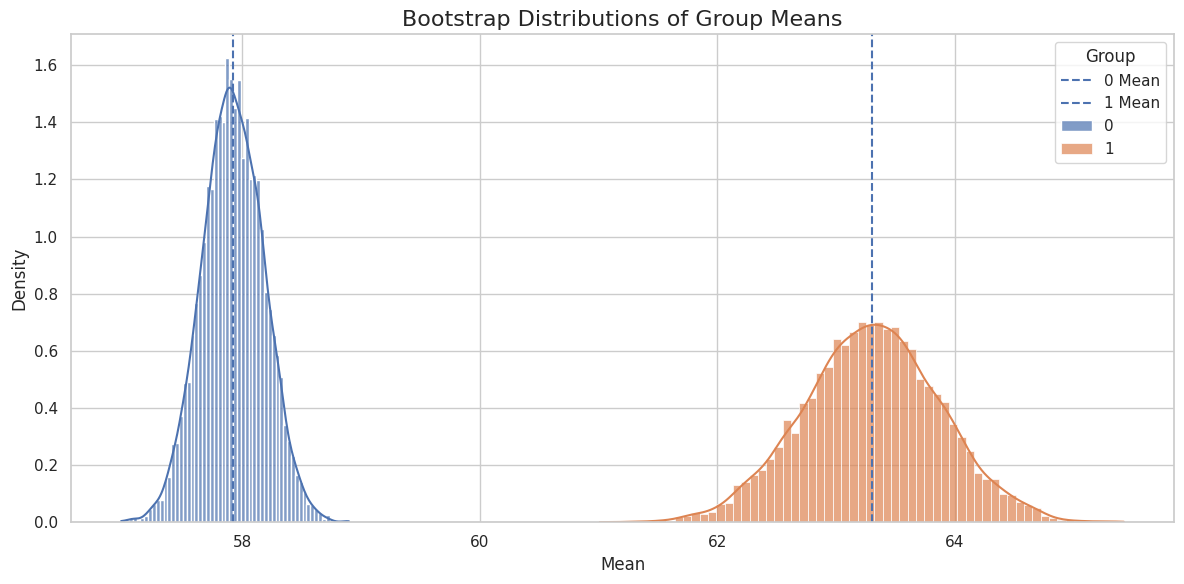

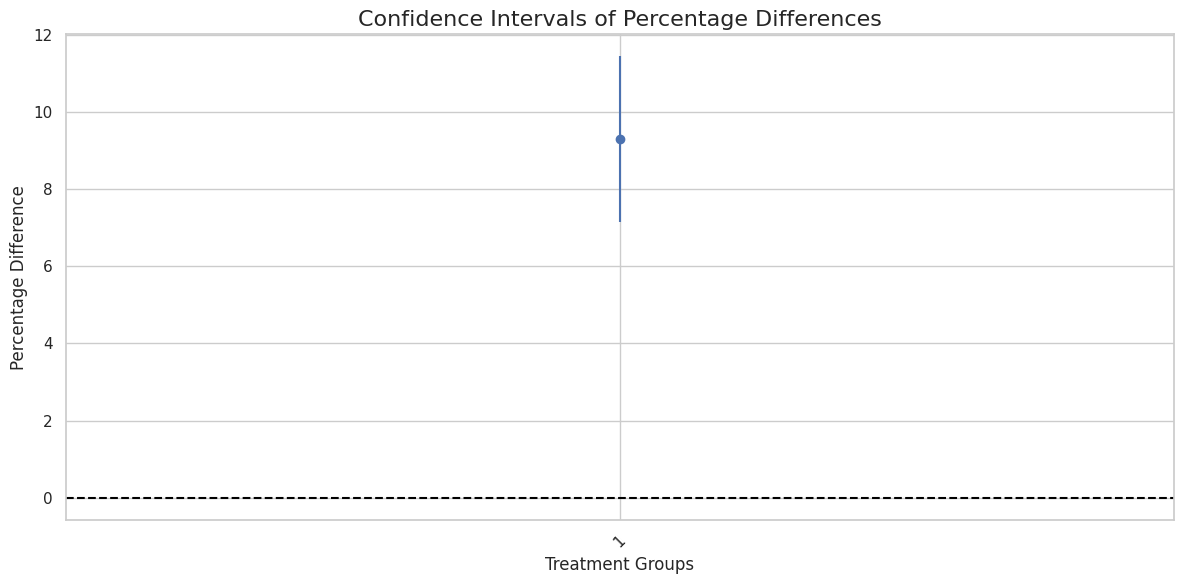

In [192]:
evaluator = BootstrapEvaluator(tmp_df, group_col="explicit", value_col="popularity_winsorized", control_group="0")
results = evaluator.evaluate(n_resamples=10000)
evaluator.plot_means_distribution()
evaluator.plot_interval()
evaluator.get_results_table()

In [185]:
genre_features = df.groupby("genre")[spotify_features + audio_extracted_features + lyrics_features].mean()

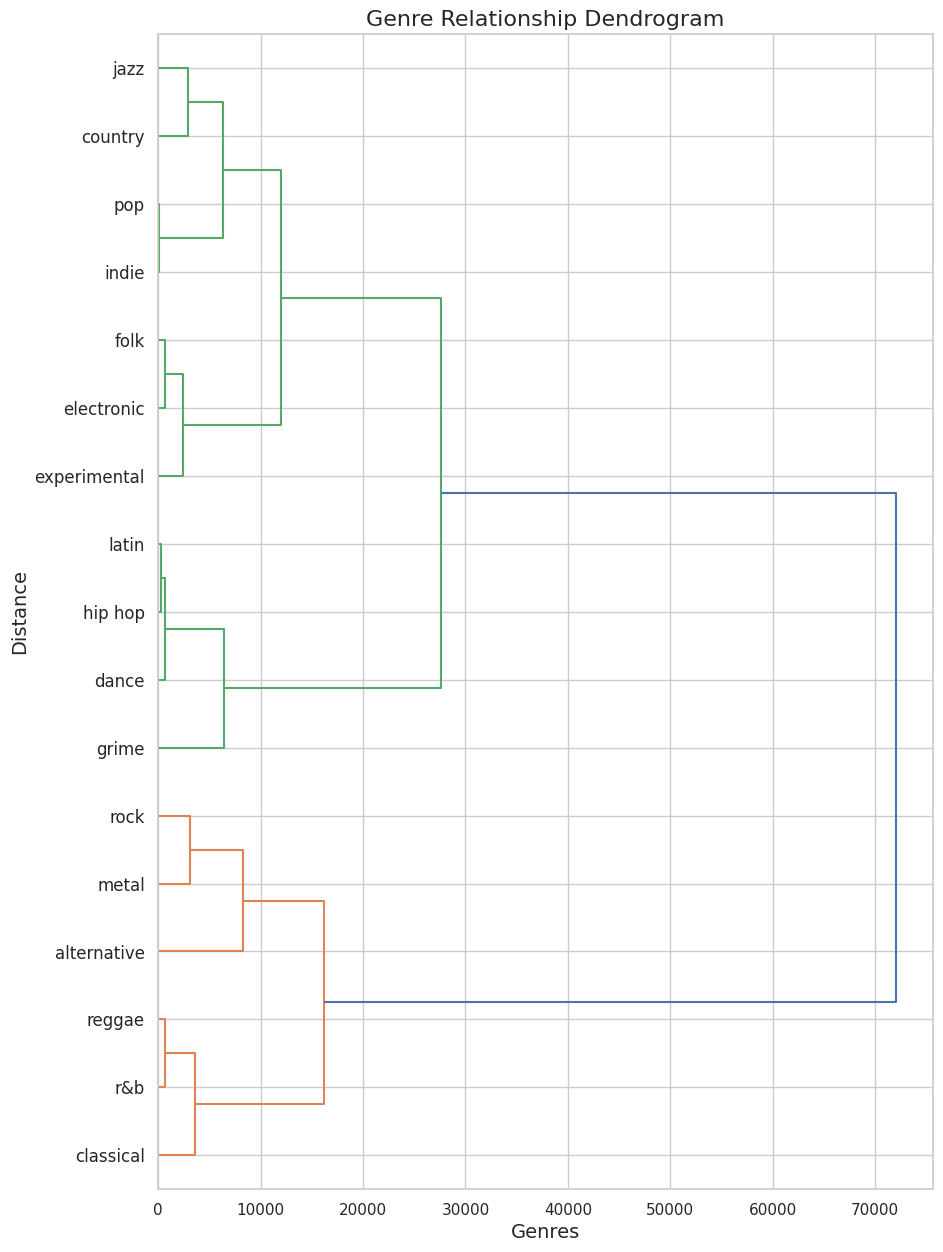

In [196]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(genre_features, method='ward')

# Create a wider plot
plt.figure(figsize=(10, 15))  # Adjust width and height
dendrogram(linkage_matrix, labels=genre_features.index,orientation='right')
plt.title("Genre Relationship Dendrogram", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.show()


<Axes: >

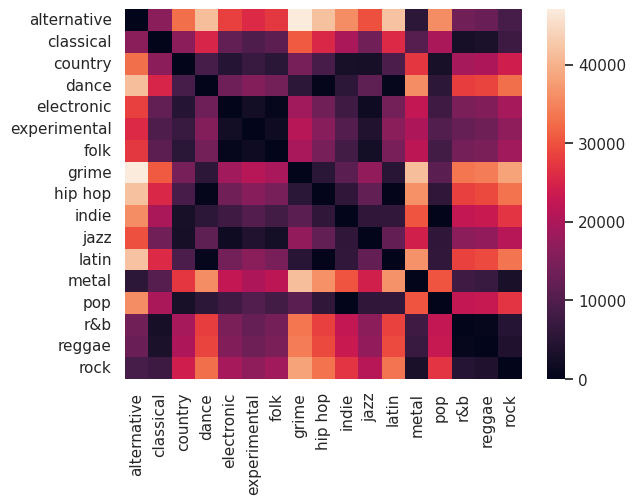

In [197]:
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(genre_features, metric='euclidean'))
sns.heatmap(distance_matrix, xticklabels=genre_features.index, yticklabels=genre_features.index)#, cmap="viridis")

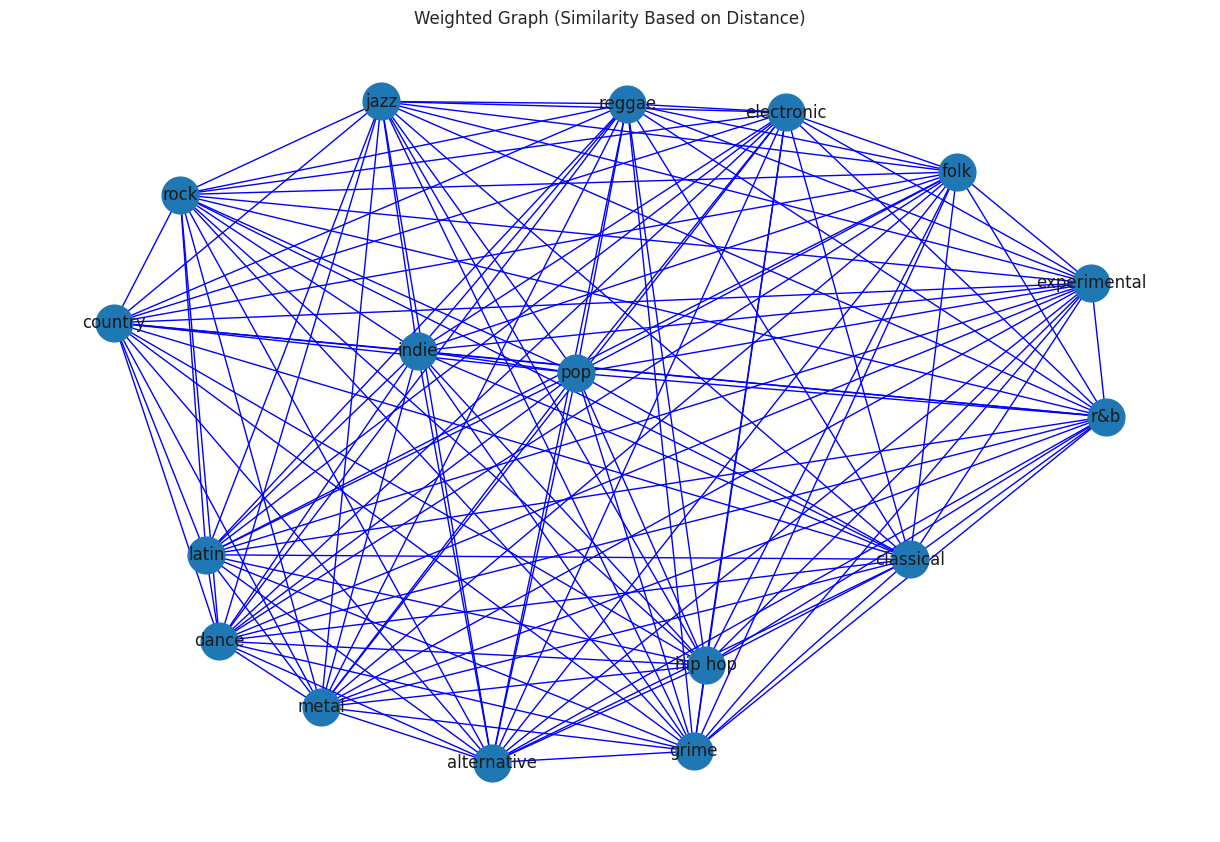

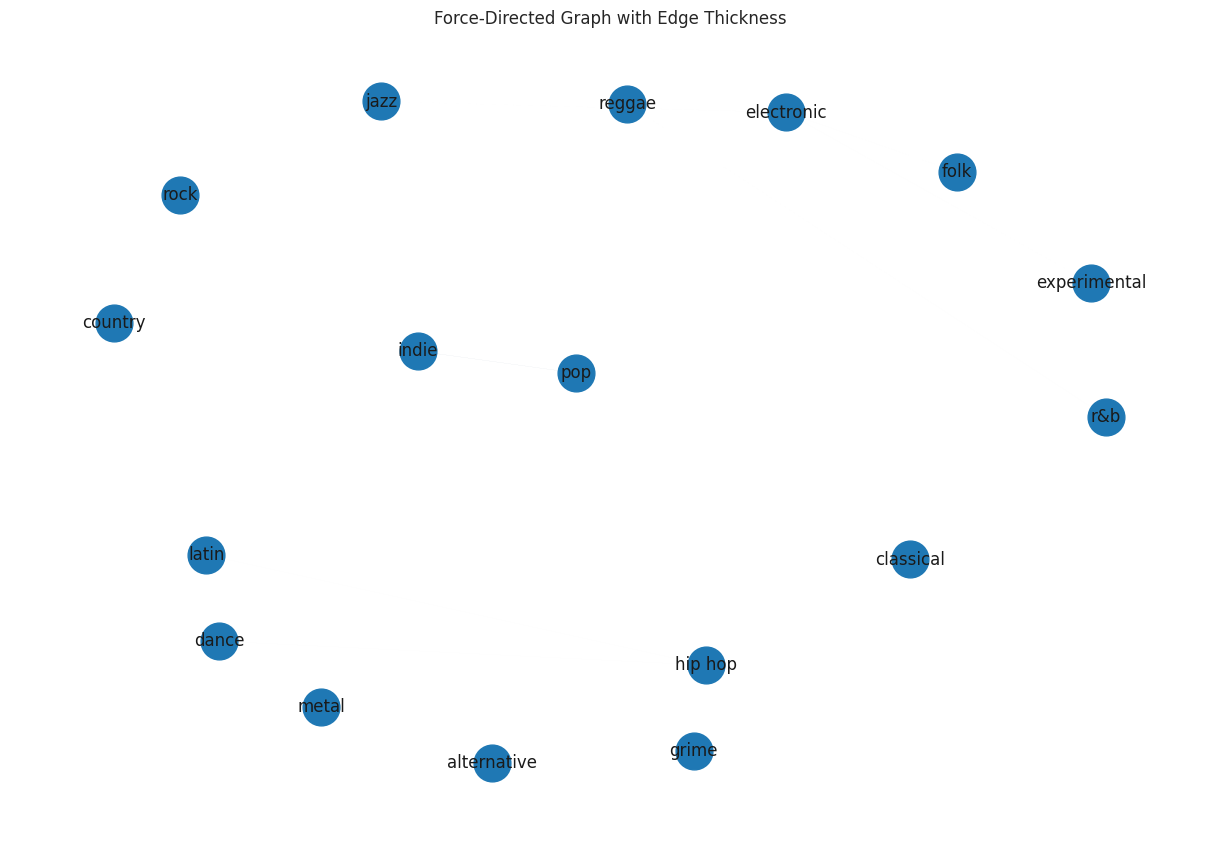

In [41]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np

# 2. Compute the Distance Matrix
distance_matrix = squareform(pdist(genre_features, metric='euclidean'))
genres = genre_features.index.tolist()

# Mapping node indices to genres
node_mapping = {i: genres[i] for i in range(len(genres))}

# 3. Weighted Graph
plt.figure(figsize=(12, 8))
G_weighted = nx.Graph()

# Add edges and nodes based on distances
for i in range(len(distance_matrix)):
    for j in range(i + 1, len(distance_matrix)):
        similarity = 1 / (distance_matrix[i, j] + 1e-5)  # Avoid division by zero
        G_weighted.add_edge(i, j, weight=similarity)

pos_weighted = nx.spring_layout(G_weighted, weight='weight')
nx.draw(G_weighted, pos_weighted, with_labels=True, labels=node_mapping,
        node_size=700, font_size=12, edge_color='blue')
plt.title("Weighted Graph (Similarity Based on Distance)")
plt.show()


# 5. Force-Directed Layout with Edge Thickness
plt.figure(figsize=(12, 8))
edges = G_weighted.edges(data=True)
edge_weights = [d['weight'] for (_, _, d) in edges]  # Extract edge weights
nx.draw(G_weighted, pos_weighted, with_labels=True, labels=node_mapping,
        node_size=700, font_size=12, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
plt.title("Force-Directed Graph with Edge Thickness")
plt.show()


# Test Lyrical Complexity and Popularity
Hypothesis: Songs with simpler lyrics (lower syllable count, higher readability) are more likely to be popular.

In [237]:
list(df.columns)

['id',
 'title',
 'artist',
 'album_art_url',
 'popularity',
 'explicit',
 'album_release_year',
 'duration_ms',
 'genres',
 'lyrics',
 'mp3_path',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'spectral_contrast_1',
 'spectral_contrast_2',
 'spectral_contrast_3',
 'spectral_contrast_4',
 'spectral_contrast_5',
 'spectral_contrast_6',
 'spectral_contrast_7',
 'tempo_extracted',
 'zcr',
 'csv_path',
 'word_count',
 'unique_word_count',
 'sentiment_polarity',
 'sentiment_subjectivity',
 'noun_ratio',
 'verb_ratio',
 'vader_compound',
 'repetition_count',
 'language',
 

# Sentiment and Genre: Sentiment polarity and subjectivity vary significantly across genres.

Hypothesis: Sentiment polarity and subjectivity vary significantly across genres.
Use clustering and sentiment analysis to group genres by sentiment characteristics.

# Temporal Trends in Features:

Hypothesis: Newer songs (recent album release years) tend to have shorter durations and simpler structures (lower syllable count, fewer unique words).
Perform a temporal analysis to verify how features evolve over time.

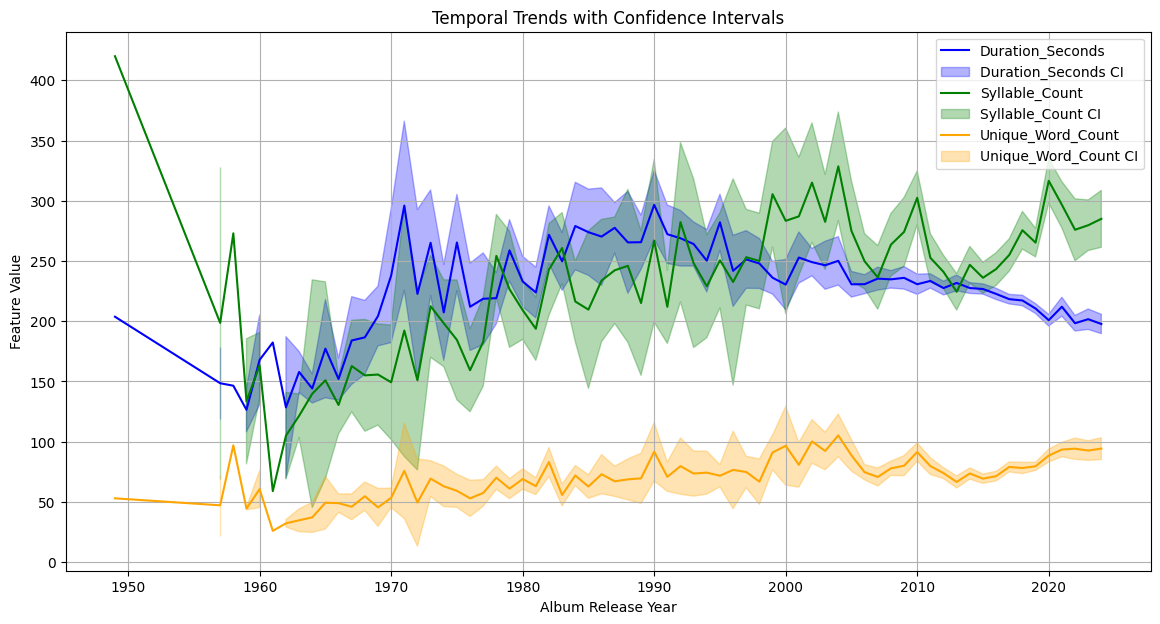

In [48]:
import numpy as np

# Group data by year and compute mean, std, and count
agg_data = df.groupby('album_release_year').agg({
    'duration_seconds': ['mean', 'std', 'count'],
    'syllable_count': ['mean', 'std', 'count'],
    'unique_word_count': ['mean', 'std', 'count']
})

# Flatten multi-level columns
agg_data.columns = ['_'.join(col) for col in agg_data.columns]

# Compute 95% confidence intervals
for feature in ['duration_seconds', 'syllable_count', 'unique_word_count']:
    mean_col = f"{feature}_mean"
    std_col = f"{feature}_std"
    count_col = f"{feature}_count"
    agg_data[f"{feature}_ci_lower"] = agg_data[mean_col] - 1.96 * (agg_data[std_col] / np.sqrt(agg_data[count_col]))
    agg_data[f"{feature}_ci_upper"] = agg_data[mean_col] + 1.96 * (agg_data[std_col] / np.sqrt(agg_data[count_col]))

# Plot temporal trends with manual confidence intervals
plt.figure(figsize=(14, 7))
for feature, color in zip(['duration_seconds', 'syllable_count', 'unique_word_count'], ['blue', 'green', 'orange']):
    plt.plot(agg_data.index, agg_data[f"{feature}_mean"], label=f"{feature.title()}", color=color)
    plt.fill_between(
        agg_data.index, 
        agg_data[f"{feature}_ci_lower"], 
        agg_data[f"{feature}_ci_upper"], 
        color=color, alpha=0.3, label=f"{feature.title()} CI"
    )
plt.title("Temporal Trends with Confidence Intervals")
plt.xlabel("Album Release Year")
plt.ylabel("Feature Value")
plt.legend()
plt.grid()
plt.show()


In [45]:
from scipy.stats import linregress

# Perform linear regression for each feature
features = ['duration_seconds', 'syllable_count', 'unique_word_count']
for feature in features:
    slope, intercept, r_value, p_value, std_err = linregress(temporal_trends['album_release_year'], temporal_trends[feature])
    print(f"{feature} vs. album_release_year:")
    print(f"  Slope = {slope:.3f}")
    print(f"  p-value = {p_value:.3e}")
    print(f"  R-squared = {r_value**2:.3f}\n")


duration_seconds vs. album_release_year:
  Slope = 0.672
  p-value = 4.029e-03
  R-squared = 0.117

syllable_count vs. album_release_year:
  Slope = 1.801
  p-value = 5.277e-08
  R-squared = 0.359

unique_word_count vs. album_release_year:
  Slope = 0.622
  p-value = 2.695e-12
  R-squared = 0.520



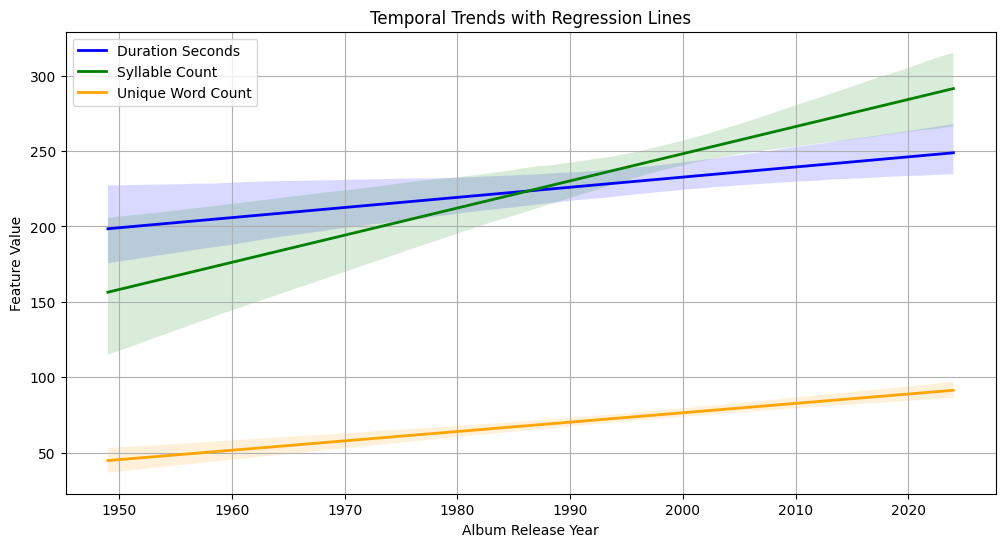

In [46]:
# Plot temporal trends with regression lines
plt.figure(figsize=(12, 6))
for feature, color in zip(['duration_seconds', 'syllable_count', 'unique_word_count'], ['blue', 'green', 'orange']):
    sns.regplot(
        data=temporal_trends, 
        x='album_release_year', 
        y=feature, 
        label=f"{feature.replace('_', ' ').title()}", 
        scatter=False, 
        color=color, 
        line_kws={'linewidth': 2}
    )
plt.title("Temporal Trends with Regression Lines")
plt.xlabel("Album Release Year")
plt.ylabel("Feature Value")
plt.legend()
plt.grid()
plt.show()


# Acoustic Features and Explicitness:

Hypothesis: Songs marked as explicit have distinct acoustic features such as higher energy or louder dynamics compared to non-explicit ones.
Use classification models to test the separability of explicit vs. non-explicit songs based on acoustic features.

In [55]:
num_acoustic_features = [
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'spectral_contrast_1',
 'spectral_contrast_2',
 'spectral_contrast_3',
 'spectral_contrast_4',
 'spectral_contrast_5',
 'spectral_contrast_6',
 'spectral_contrast_7',
 'tempo_extracted',
 'zcr',
]
cat_acoustic_features = ['key', 'mode', 'time_signature']

# Optimal Classification

In [56]:
from classes.model_pipeline import OptimalClassificationPipeline

In [67]:
target = 'explicit'

In [68]:
cat_acoustic_features

['key', 'mode', 'time_signature']

In [69]:
clf_pipeline = OptimalClassificationPipeline(
    df.dropna(subset=[target]),
    target_column=target,
    num_features=num_acoustic_features,
    cat_features=cat_acoustic_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
clf_pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline...
INFO: Setting up the pipeline...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mfcc_1', 'mfcc_2',
                                                   'mfcc_3', 'mfcc_4', 'mfcc_5',
                                                   'mfcc_6', 'mfcc_7', 'mfcc...
                                                   'mfcc_13', 'chroma_1',
                                                   'chroma_2', 'chroma_3',
                                                   'chroma_4', 'chroma_5',
                                                   'chroma_6', 'chroma_7',
                                                   'chroma_8', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant'))]),
                                                  ['key', 'mode',
                                                   'time_signature'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x74207a816c80>)])

In [70]:
clf_pipeline.split()
clf_pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-07 04:16:04,198] A new study created in RDB with name: catboost_explicit
[I 2024-12-07 04:17:30,999] Trial 4 finished with value: 0.8408946687843801 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.014607742440101464, 'l2_leaf_reg': 5.287981392986355}. Best is trial 4 with value: 0.8408946687843801.
[I 2024-12-07 04:17:31,639] Trial 0 finished with value: 0.867385932866517 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.03286569561456673, 'l2_leaf_reg': 3.4520474287255065}. Best is trial 0 with value: 0.867385932866517.
[I 2024-12-07 04:17:32,352] Trial 7 finished with value: 0.8727845401516923 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.06273065944160273, 'l2_leaf_reg': 5.29293724278514}. Best is trial 7 with value: 0.8727845401516923.
[I 2024-12-07 04:18:35,562] Trial 5 finished with value: 0.8809689358646227 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.03823748769883058, 'l2_leaf_reg': 9

INFO: Pipeline training completed.


In [71]:
clf_pipeline.model.training_results

Metric  Score
0   Accuracy  0.893
1   F1 Score  0.885
2  Precision  0.885
3     Recall  0.893

INFO: Evaluating the model...


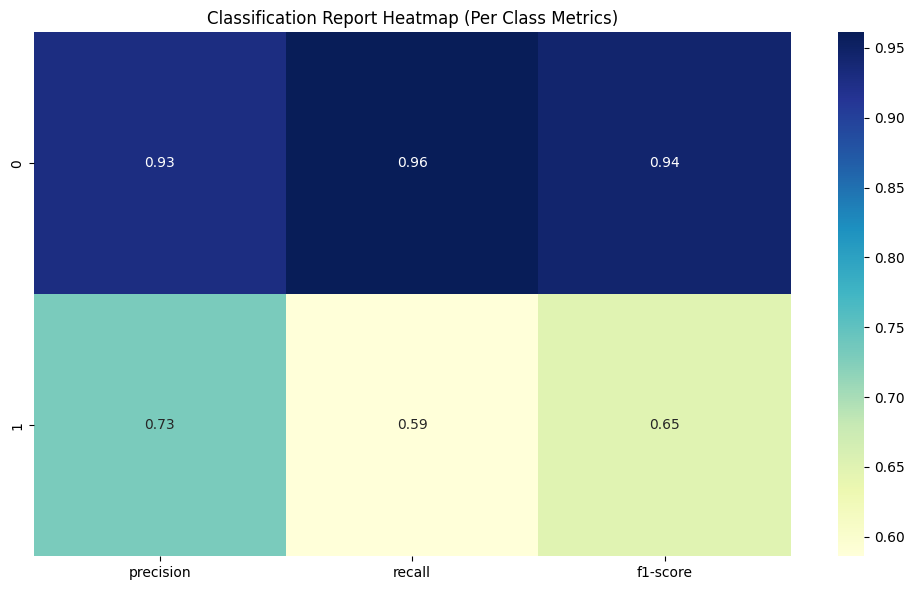

precision    recall  f1-score      support
0              0.928177  0.961098  0.944351   874.000000
1              0.730159  0.585987  0.650177   157.000000
accuracy       0.903977  0.903977  0.903977     0.903977
macro avg      0.829168  0.773543  0.797264  1031.000000
weighted avg   0.898023  0.903977  0.899554  1031.000000

In [72]:
clf_pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


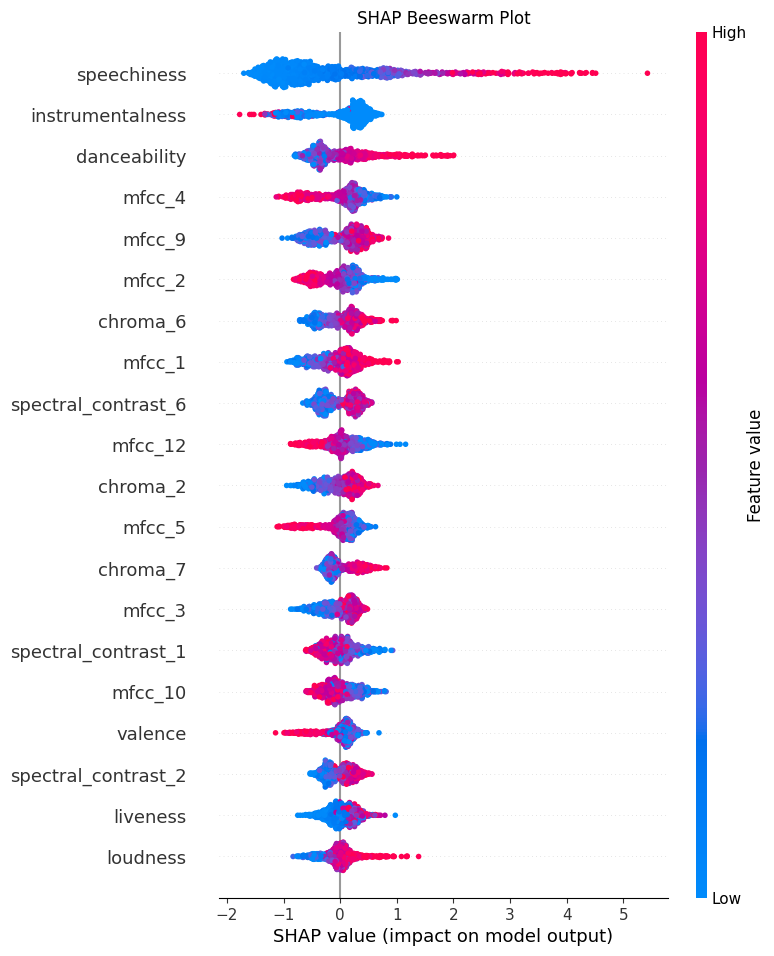

INFO: Generating feature importance bar plot...


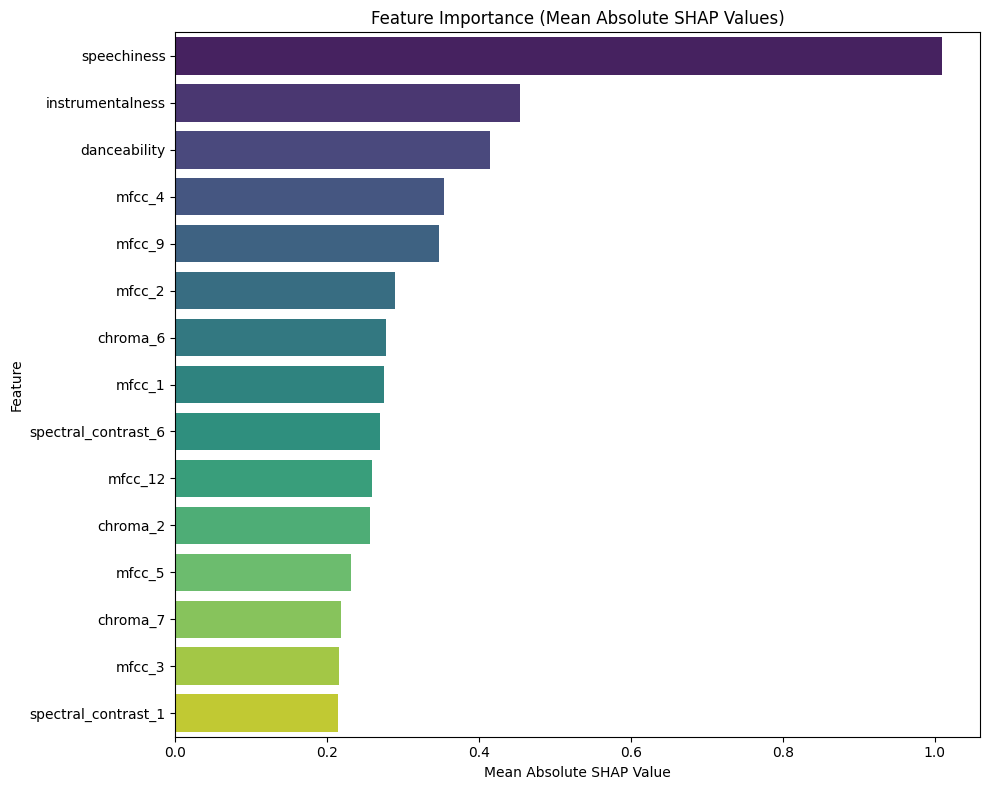

In [73]:
clf_pipeline.perform_shap_analysis()

# Genre-Specific Analysis
Objective: Investigate which acoustic or textual features dominate specific genres.

In [88]:
df = df[df.genre != 'None']

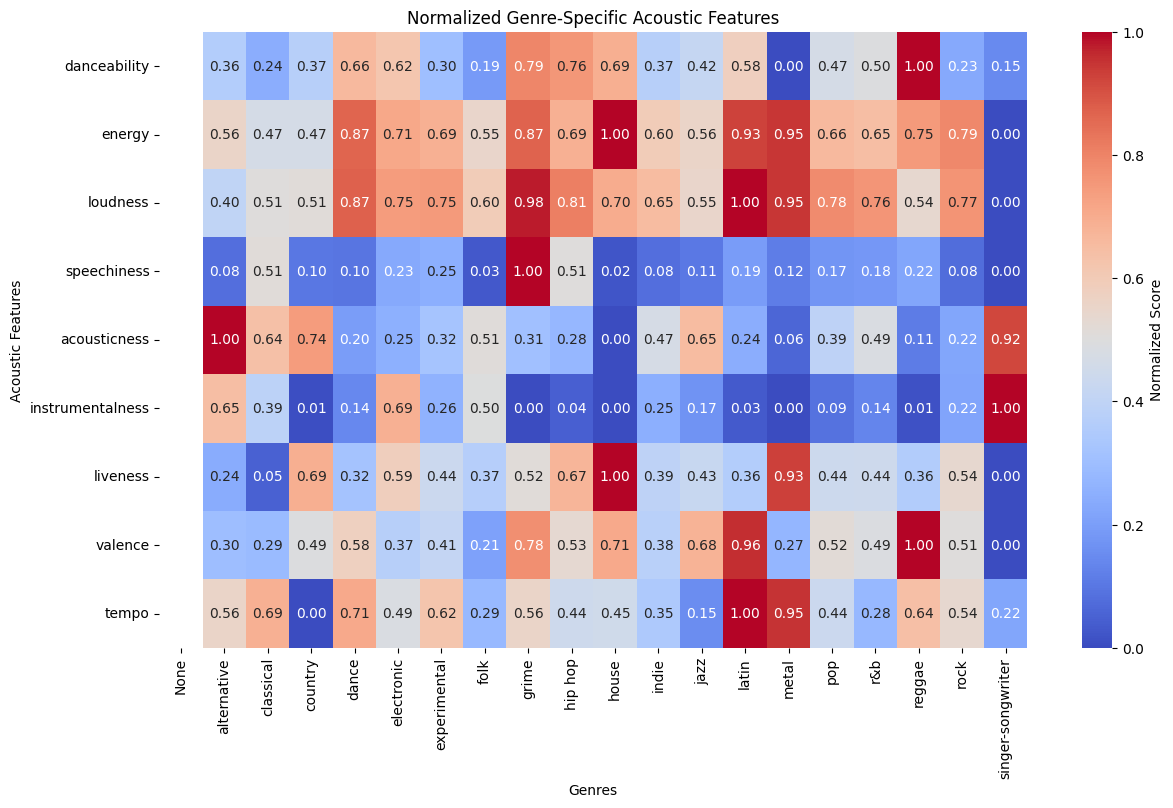

In [91]:
from sklearn.preprocessing import MinMaxScaler

# Select only the relevant features for normalization
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo']

# Group by genre and calculate mean acoustic features
genre_means = df.groupby('genre')[features].mean()

# Normalize each feature across genres using MinMaxScaler
scaler = MinMaxScaler()
normalized_genre_means = pd.DataFrame(scaler.fit_transform(genre_means), 
                                      columns=genre_means.columns, 
                                      index=genre_means.index)

# Heatmap to visualize normalized dominant features
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_genre_means.T, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Normalized Score'})
plt.title("Normalized Genre-Specific Acoustic Features")
plt.xlabel("Genres")
plt.ylabel("Acoustic Features")
plt.show()


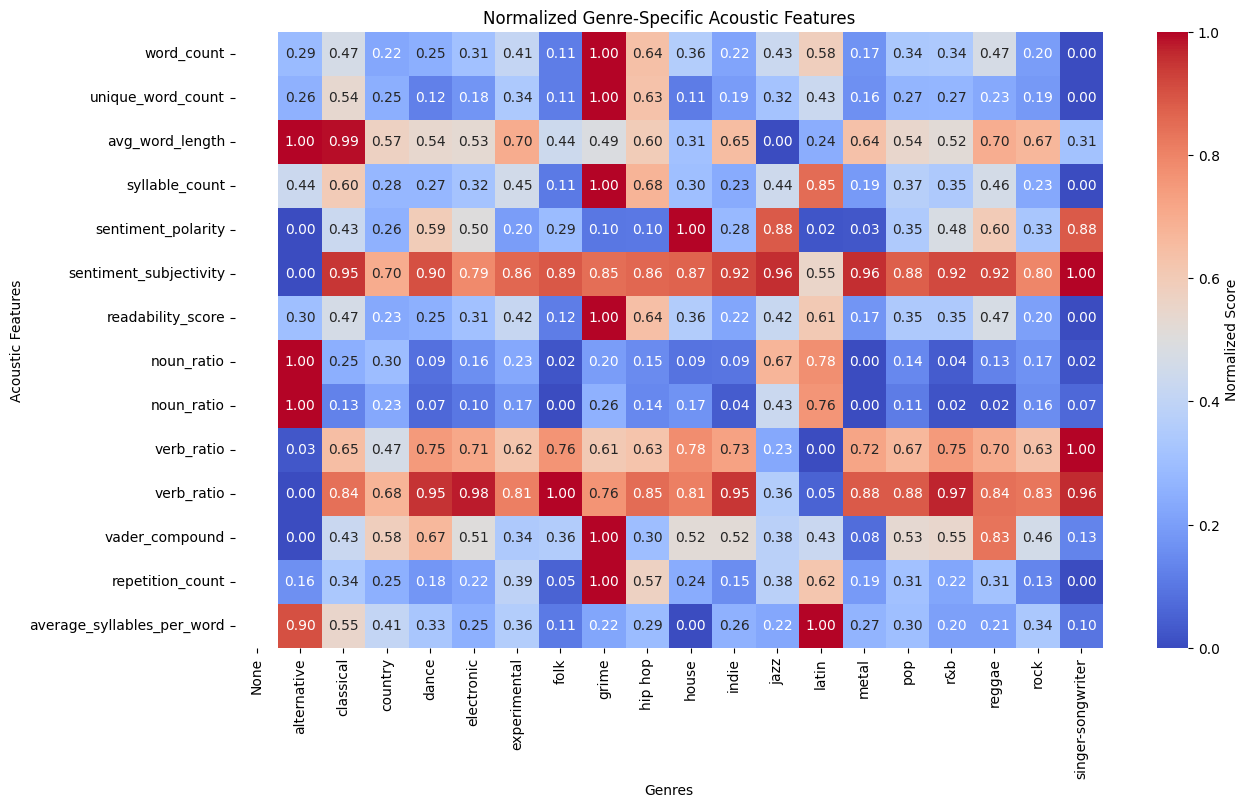

In [93]:
from sklearn.preprocessing import MinMaxScaler

genre_means = df.groupby('genre')[lyrics_features].mean()

# Normalize each feature across genres using MinMaxScaler
scaler = MinMaxScaler()
normalized_genre_means = pd.DataFrame(scaler.fit_transform(genre_means), 
                                      columns=genre_means.columns, 
                                      index=genre_means.index)

# Heatmap to visualize normalized dominant features
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_genre_means.T, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Normalized Score'})
plt.title("Normalized Genre-Specific Acoustic Features")
plt.xlabel("Genres")
plt.ylabel("Acoustic Features")
plt.show()

# Co-occurrence Patterns in Textual Data
Objective: Perform topic modeling or co-occurrence analysis to uncover common themes or phrases in lyrics.

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize lyrics
lyrics_texts = df['lyrics'].dropna()
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_lyrics = vectorizer.fit_transform(lyrics_texts)

# Perform LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lyrics)

# Display topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))


Topic 0:
la, na, da, tu, le, je, di, che, non, se
Topic 1:
love, like, time, ill, know, danc, come, run, better, feel
Topic 2:
que, bitch, ya, te, yo, come, el, la, nigga, uh
Topic 3:
love, im, know, dont, oh, feel, say, let, caus, heart
Topic 4:
im, yeah, like, oh, got, dont, know, babi, girl, want


### Correlating topics with genres

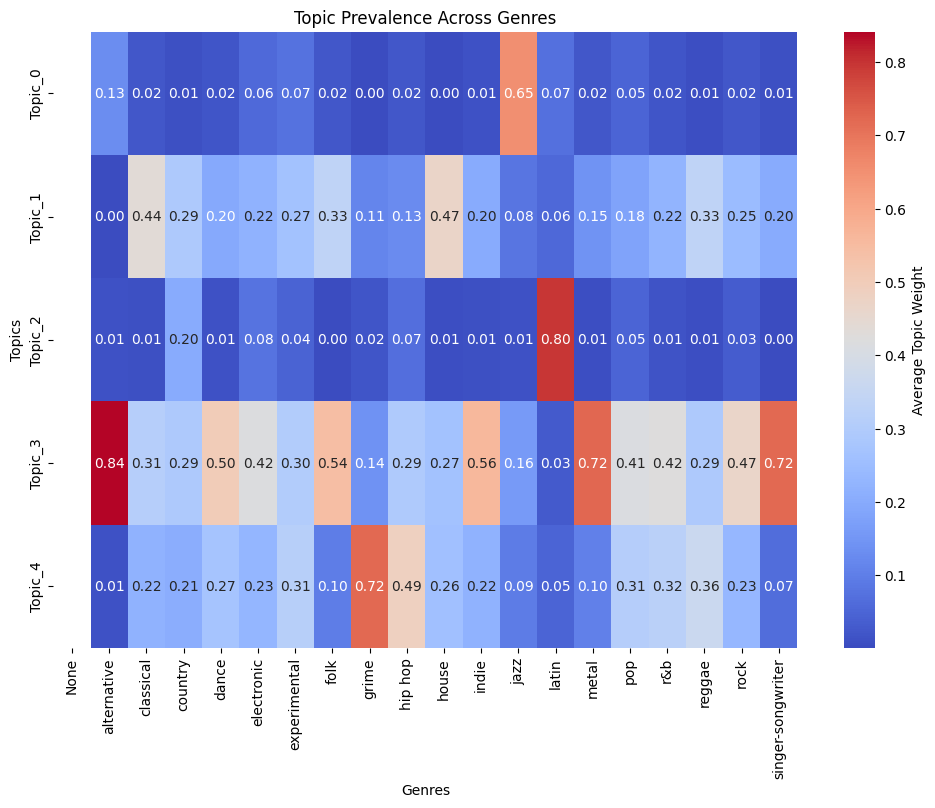

In [96]:
import numpy as np
import pandas as pd

# Get topic distributions for each song
topic_distributions = lda.transform(X_lyrics)

# Add topic weights to the DataFrame
topic_columns = [f"Topic_{i}" for i in range(lda.n_components)]
df_topics = pd.DataFrame(topic_distributions, columns=topic_columns, index=lyrics_texts.index)
df = df.join(df_topics)

# Group by genre and calculate mean topic proportions
topic_genre_means = df.groupby('genre')[topic_columns].mean()

# Visualize topic prevalence by genre
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(topic_genre_means.T, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Average Topic Weight'})
plt.title("Topic Prevalence Across Genres")
plt.xlabel("Genres")
plt.ylabel("Topics")
plt.show()


# Impact of Acoustic and Textual Interplay
Objective: Investigate how textual features amplify acoustic features' effect on popularity.

Correlation between sentiment and valence: 0.044, p-value = 0.002


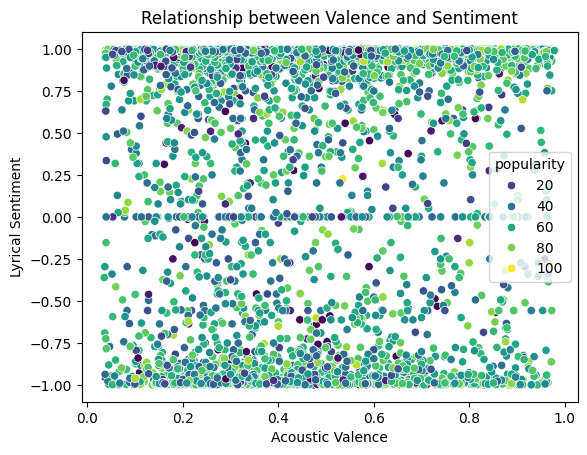

In [100]:
import scipy.stats as stats

# Correlation between sentiment (vader_compound) and valence
sentiment = df['vader_compound']
valence = df['valence']

correlation, p_value = stats.pearsonr(sentiment, valence)
print(f"Correlation between sentiment and valence: {correlation:.3f}, p-value = {p_value:.3f}")

# Scatterplot
sns.scatterplot(x=valence, y=sentiment, hue=df['popularity'], palette="viridis")
plt.title("Relationship between Valence and Sentiment")
plt.xlabel("Acoustic Valence")
plt.ylabel("Lyrical Sentiment")
plt.show()


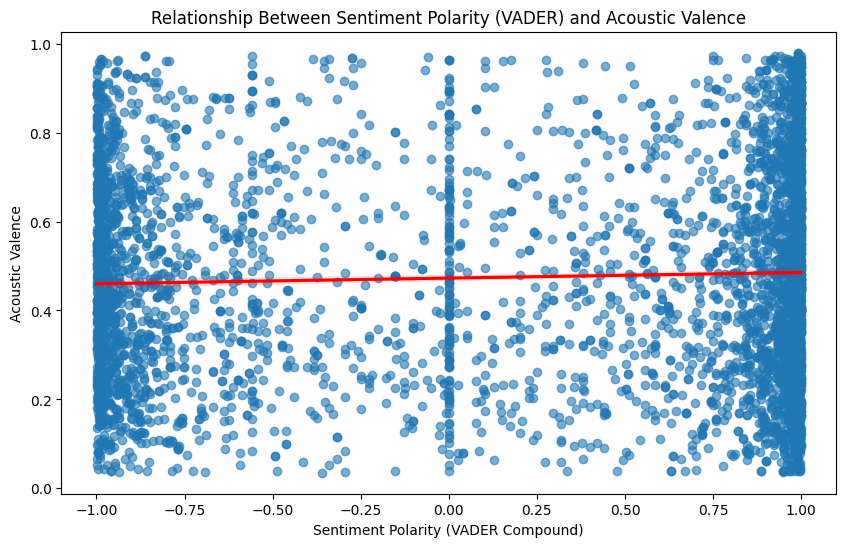

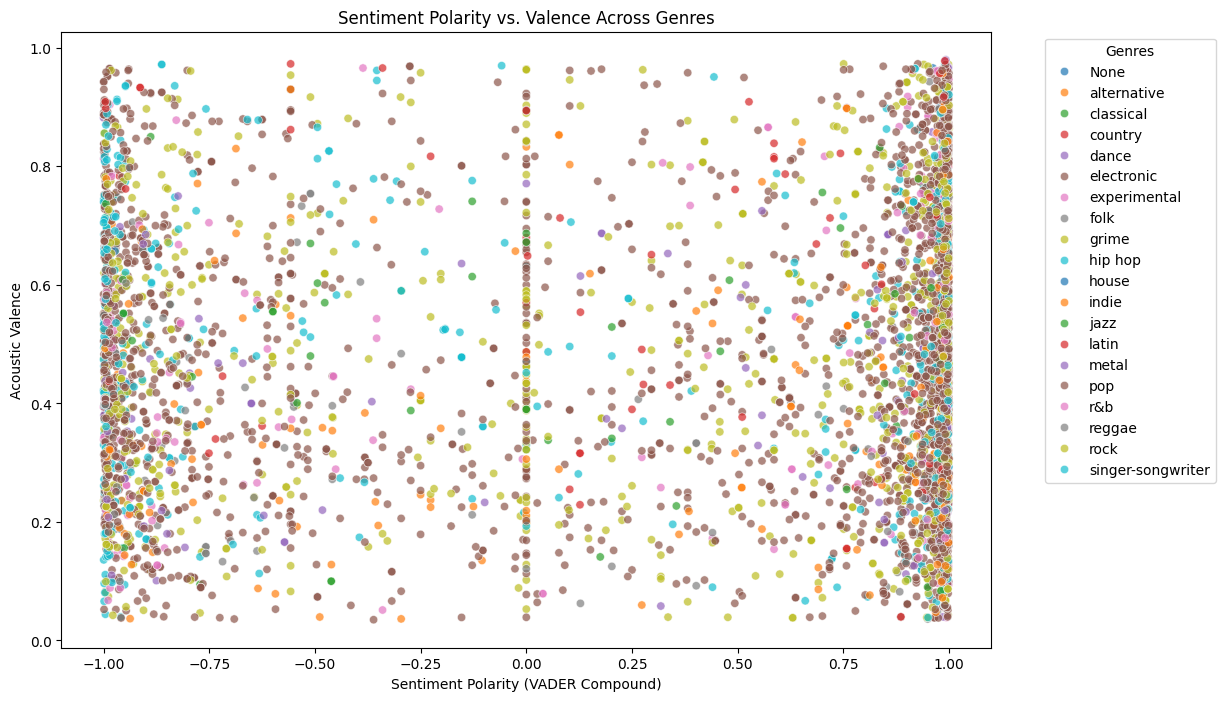

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x='vader_compound', 
    y='valence', 
    data=df, 
    scatter_kws={'alpha': 0.6}, 
    line_kws={'color': 'red'}
)
plt.title("Relationship Between Sentiment Polarity (VADER) and Acoustic Valence")
plt.xlabel("Sentiment Polarity (VADER Compound)")
plt.ylabel("Acoustic Valence")
plt.show()

# Optional: Scatterplot with genres as hue
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='vader_compound', 
    y='valence', 
    hue='genre', 
    data=df, 
    palette='tab10', 
    alpha=0.7
)
plt.title("Sentiment Polarity vs. Valence Across Genres")
plt.xlabel("Sentiment Polarity (VADER Compound)")
plt.ylabel("Acoustic Valence")
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [102]:
from scipy.stats import pearsonr

# Compute correlation
correlation, p_value = pearsonr(df['vader_compound'], df['valence'])
print(f"Correlation between sentiment polarity and valence: {correlation:.3f}, p-value: {p_value:.3e}")

# Interpretation
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Correlation between sentiment polarity and valence: 0.044, p-value: 1.688e-03
The correlation is statistically significant.


Correlation coefficient: 0.044
This indicates a very weak positive linear relationship. Sentiment polarity slightly aligns with valence, but the relationship is minimal.

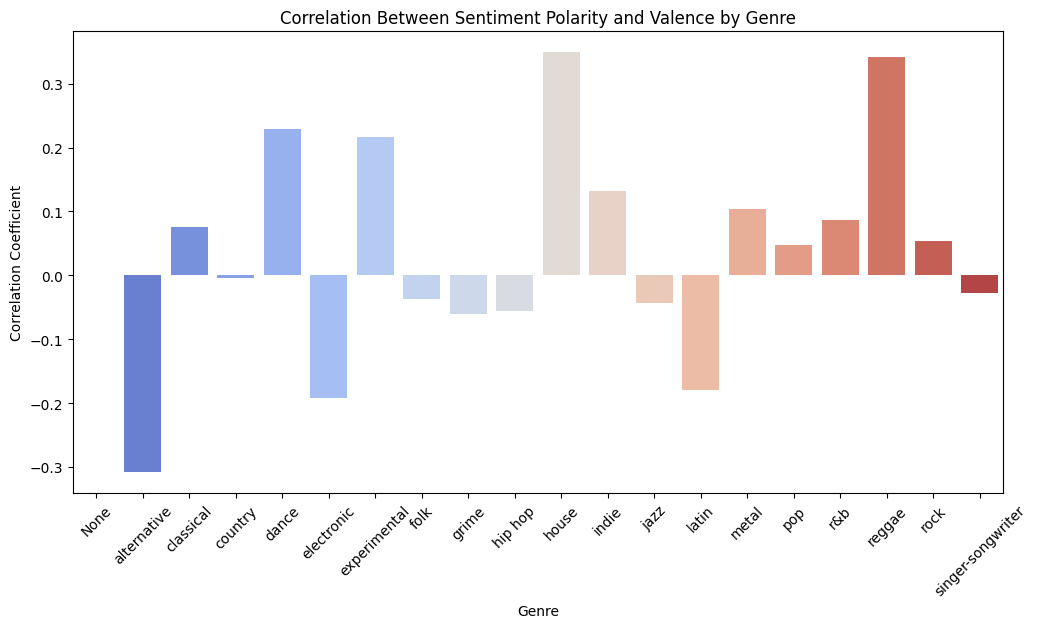

In [103]:
# Group by genre and calculate correlations
genre_correlations = (
    df.groupby('genre')[['vader_compound', 'valence']]
    .corr().unstack().iloc[:, 1]  # Extract correlation between 'vader_compound' and 'valence'
)

# Plot correlations per genre
genre_correlations = genre_correlations.reset_index()
genre_correlations.columns = ['genre', 'correlation']
plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='correlation', data=genre_correlations, palette='coolwarm')
plt.title("Correlation Between Sentiment Polarity and Valence by Genre")
plt.xlabel("Genre")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.show()


# Change in features over time
Looking for trends in features over time by plotting features with highest correlation with album_release_year

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations with album_release_year
correlations = df.corr()['album_release_year'].sort_values(ascending=False)

# Display the top 10 features most correlated with album release year
print("Top Features Correlated with Album Release Year:")
print(correlations.head(10))

# Extract top features
top_features = correlations.head(10).index


Top Features Correlated with Album Release Year:
album_release_year         1.000000
mfcc_3                     0.342181
repetition_count           0.195673
spectral_contrast_2        0.177705
text_acoustic_interplay    0.174282
loudness                   0.171083
tfidf_3                    0.143689
spectral_contrast_3        0.143179
syllable_count             0.117180
word_count                 0.114399
Name: album_release_year, dtype: float64


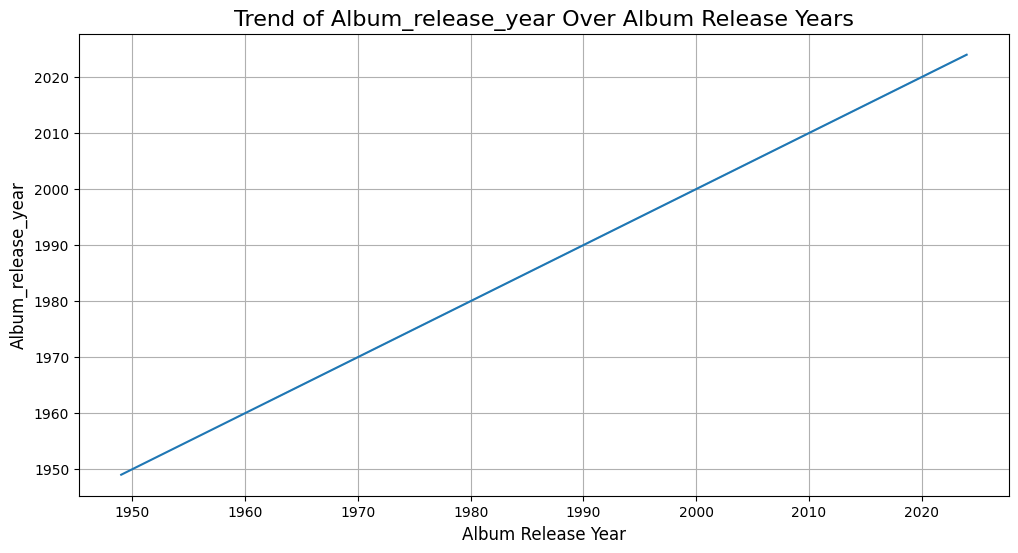

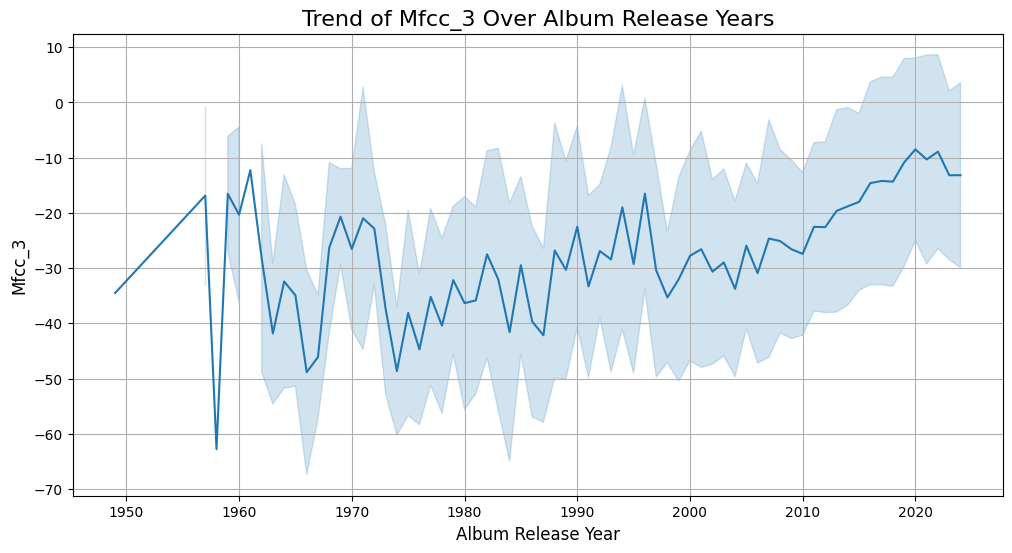

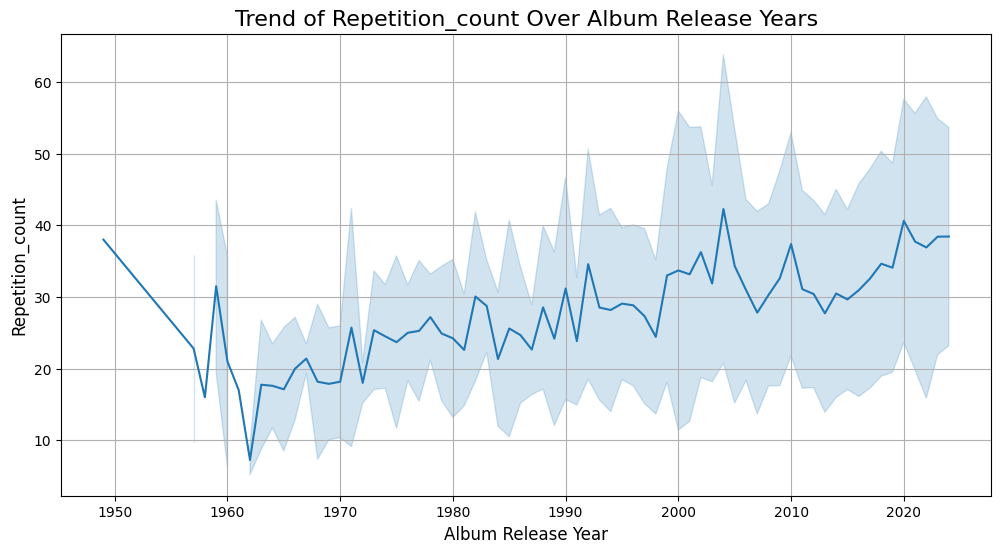

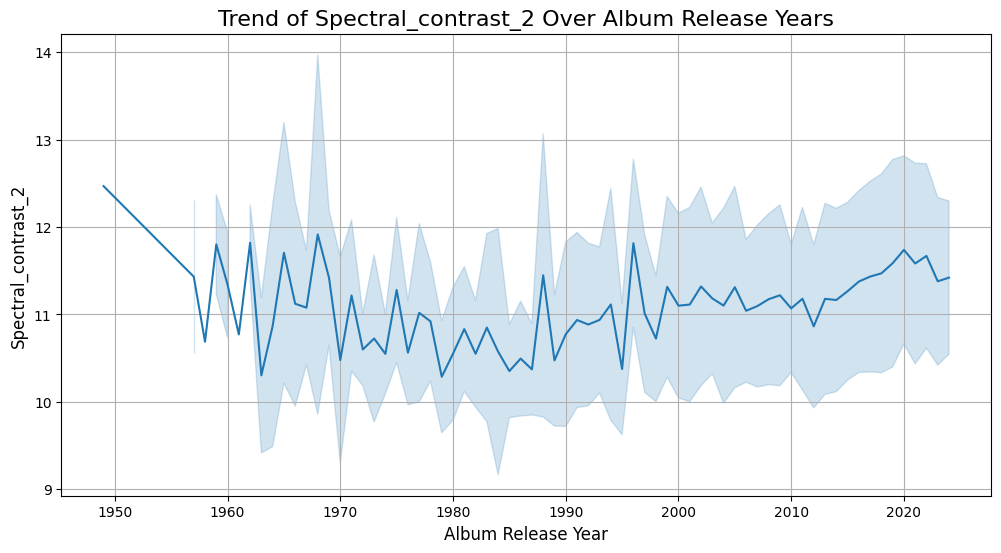

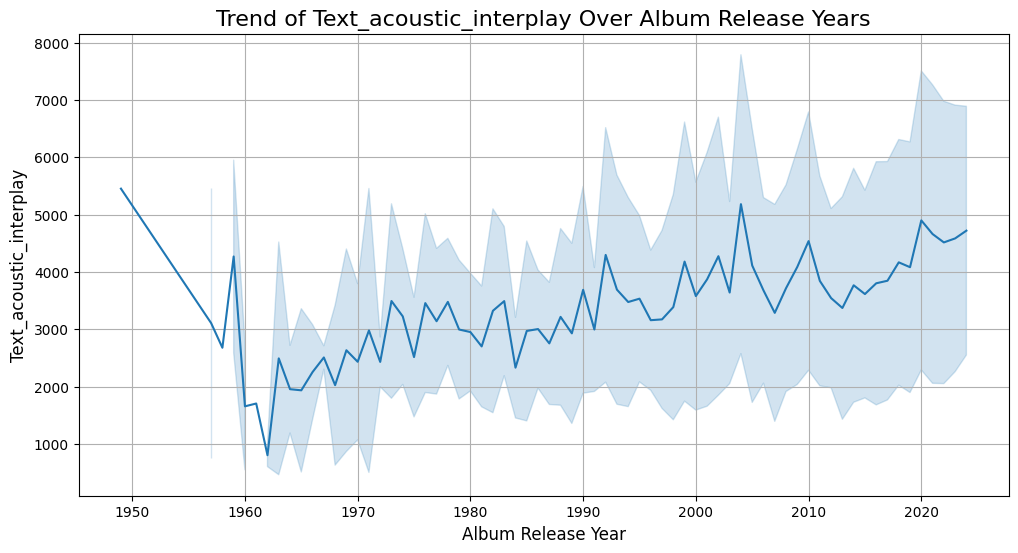

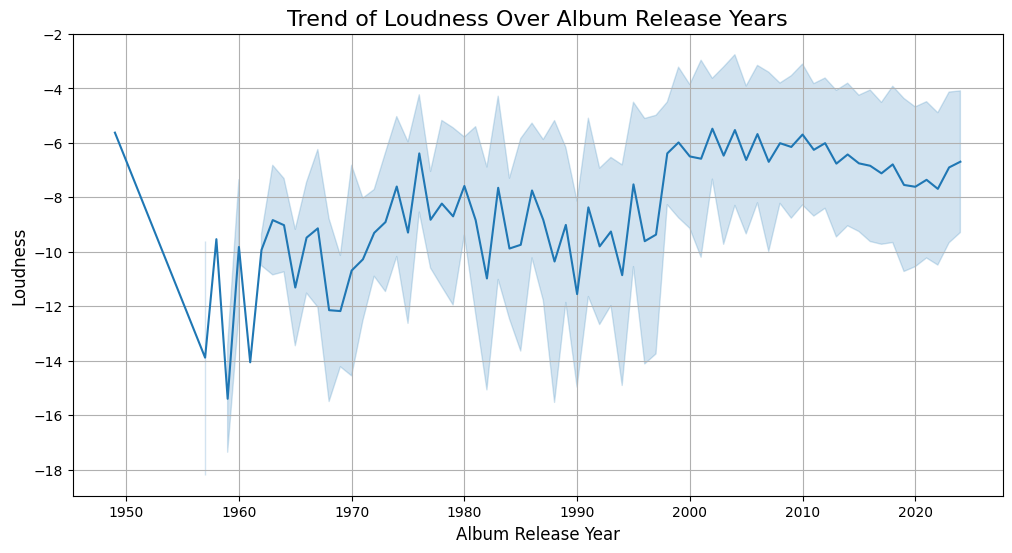

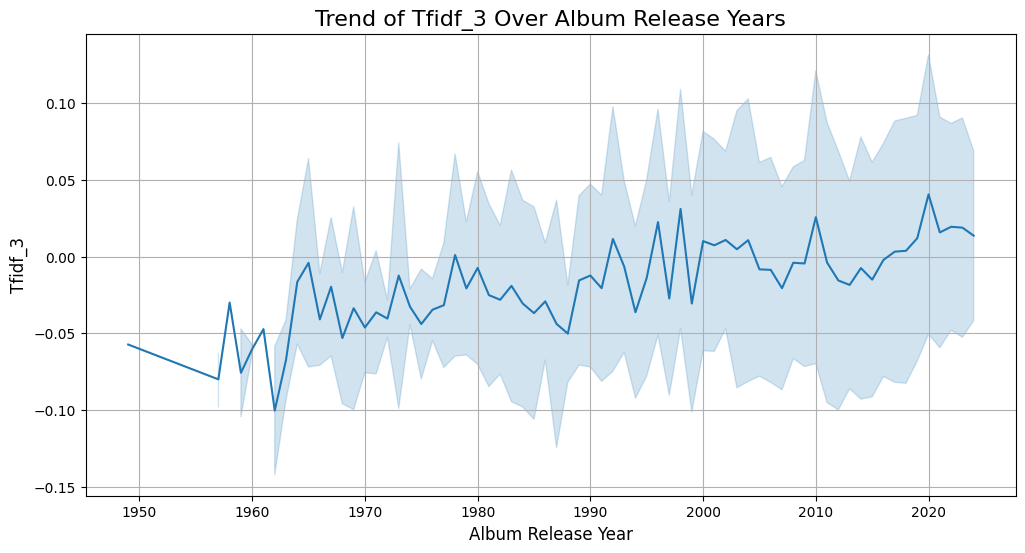

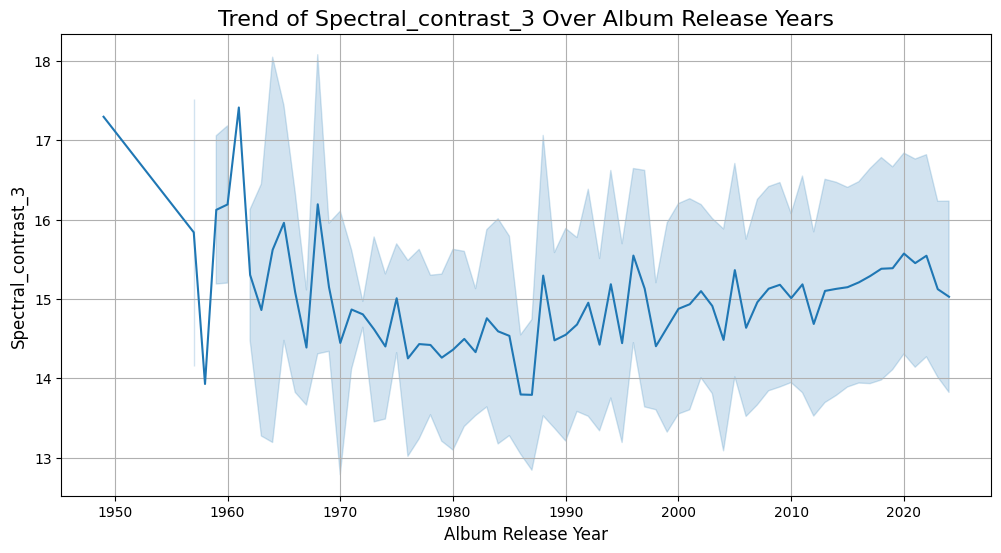

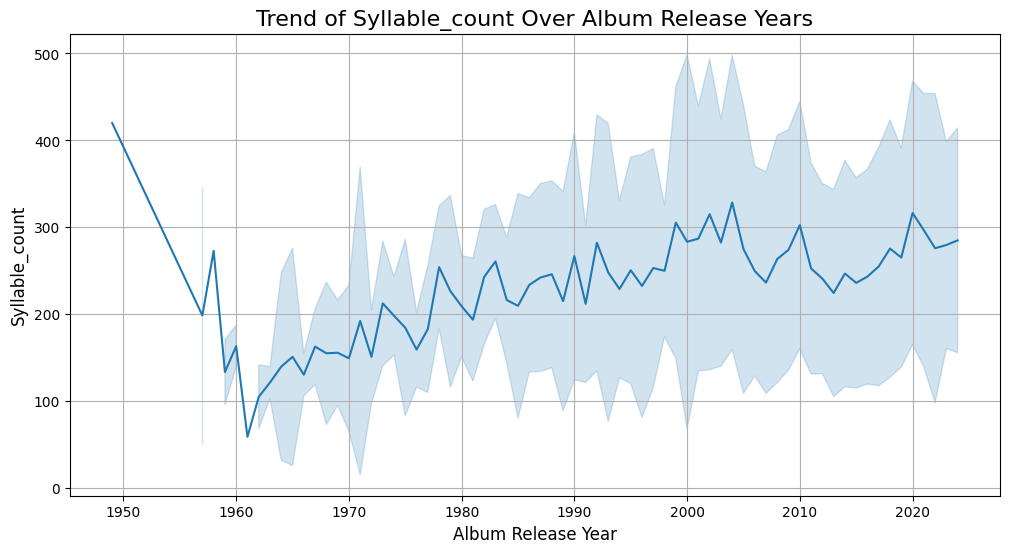

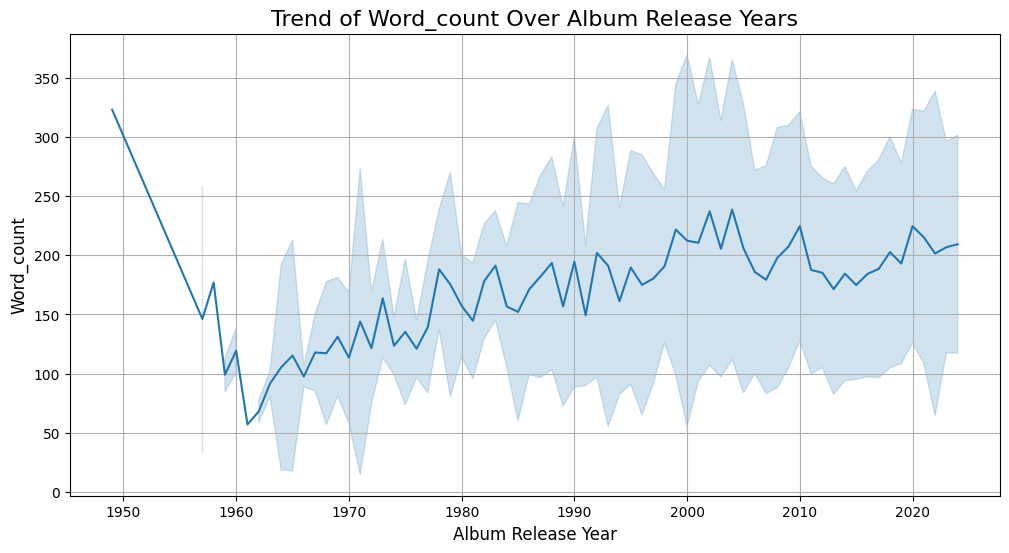

In [118]:
# Plot trends for the top correlated features
for feature in top_features:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='album_release_year', y=feature, ci='sd')  # Add confidence intervals
    plt.title(f'Trend of {feature.capitalize()} Over Album Release Years', fontsize=16)
    plt.xlabel('Album Release Year', fontsize=12)
    plt.ylabel(f'{feature.capitalize()}', fontsize=12)
    plt.grid(True)
    plt.show()


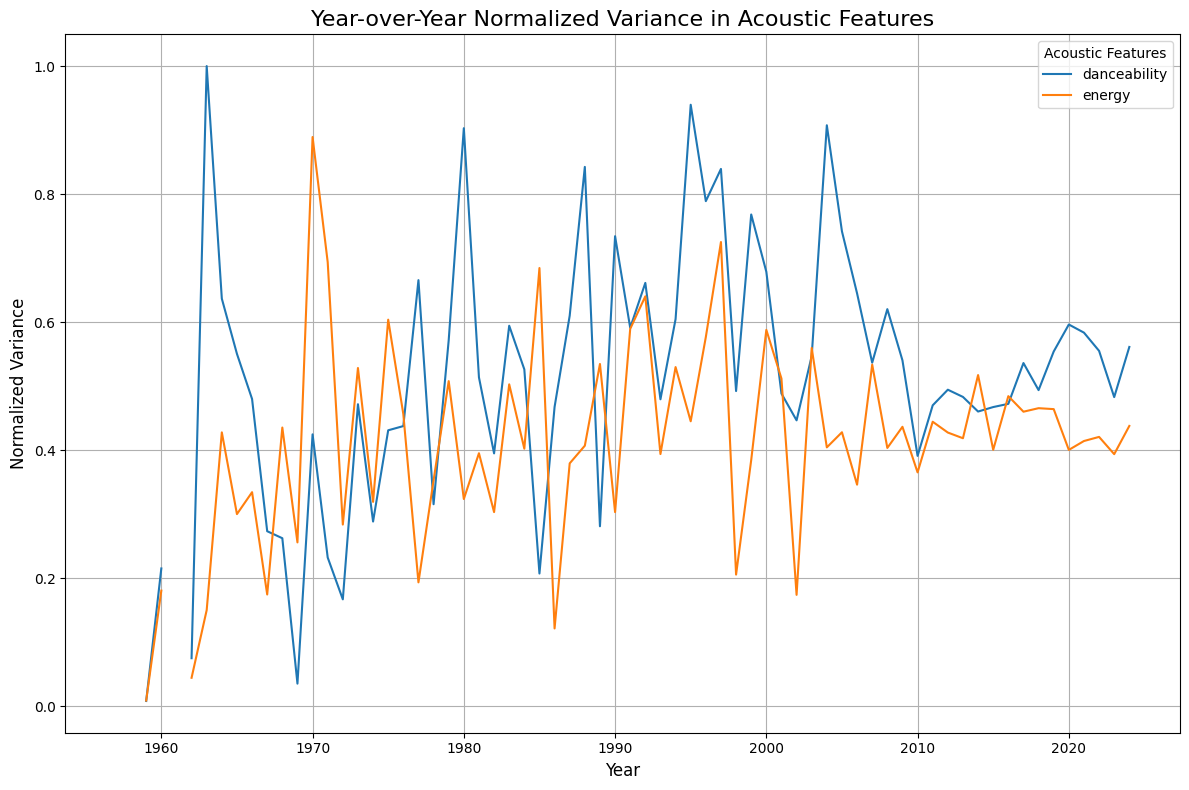

In [139]:
# I think this doesnt make sense since i have more samples for newer songs
import matplotlib.pyplot as plt
import seaborn as sns

# Select acoustic features for analysis
acoustic_features = ['danceability', 'energy',]# 'loudness', 'valence', 'tempo']

# Calculate year-over-year variance for acoustic features
feature_variance = df.groupby('album_release_year')[acoustic_features].var()

# Normalize the variance values for each feature
normalized_variance = feature_variance / feature_variance.max()

# Plot the normalized variance of each feature over time
plt.figure(figsize=(12, 8))
for feature in acoustic_features:
    plt.plot(normalized_variance.index, normalized_variance[feature], label=feature)

plt.title("Year-over-Year Normalized Variance in Acoustic Features", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Variance", fontsize=12)
plt.legend(title="Acoustic Features")
plt.grid(True)
plt.tight_layout()
plt.show()


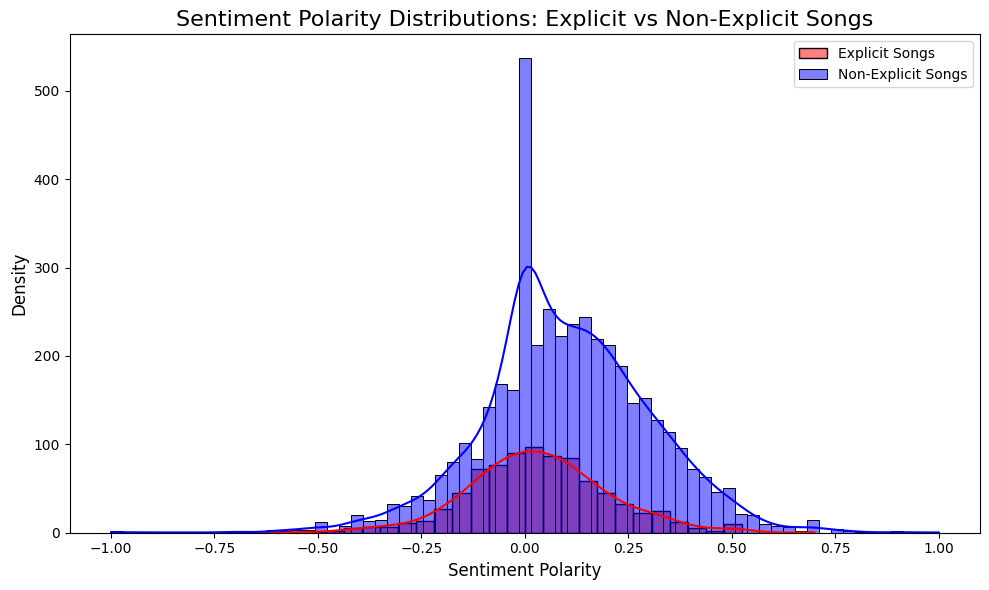

T-Test Results: t-statistic = -8.859, p-value = 1.094e-18
Reject H₀: Significant difference in sentiment polarity between explicit and non-explicit songs.


In [141]:
from scipy.stats import ttest_ind

# Separate explicit and non-explicit songs
explicit_songs = df[df['explicit'] == '1']
non_explicit_songs = df[df['explicit'] == '0']

# Calculate mean sentiment polarity for explicit vs. non-explicit songs
explicit_polarity = explicit_songs['sentiment_polarity'].dropna()
non_explicit_polarity = non_explicit_songs['sentiment_polarity'].dropna()

# Perform t-test to compare the distributions
t_stat, p_value = ttest_ind(explicit_polarity, non_explicit_polarity)

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(explicit_polarity, kde=True, color="red", label="Explicit Songs")
sns.histplot(non_explicit_polarity, kde=True, color="blue", label="Non-Explicit Songs")
plt.title("Sentiment Polarity Distributions: Explicit vs Non-Explicit Songs", fontsize=16)
plt.xlabel("Sentiment Polarity", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Display results
print(f"T-Test Results: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")
if p_value < 0.05:
    print("Reject H₀: Significant difference in sentiment polarity between explicit and non-explicit songs.")
else:
    print("Fail to reject H₀: No significant difference in sentiment polarity.")


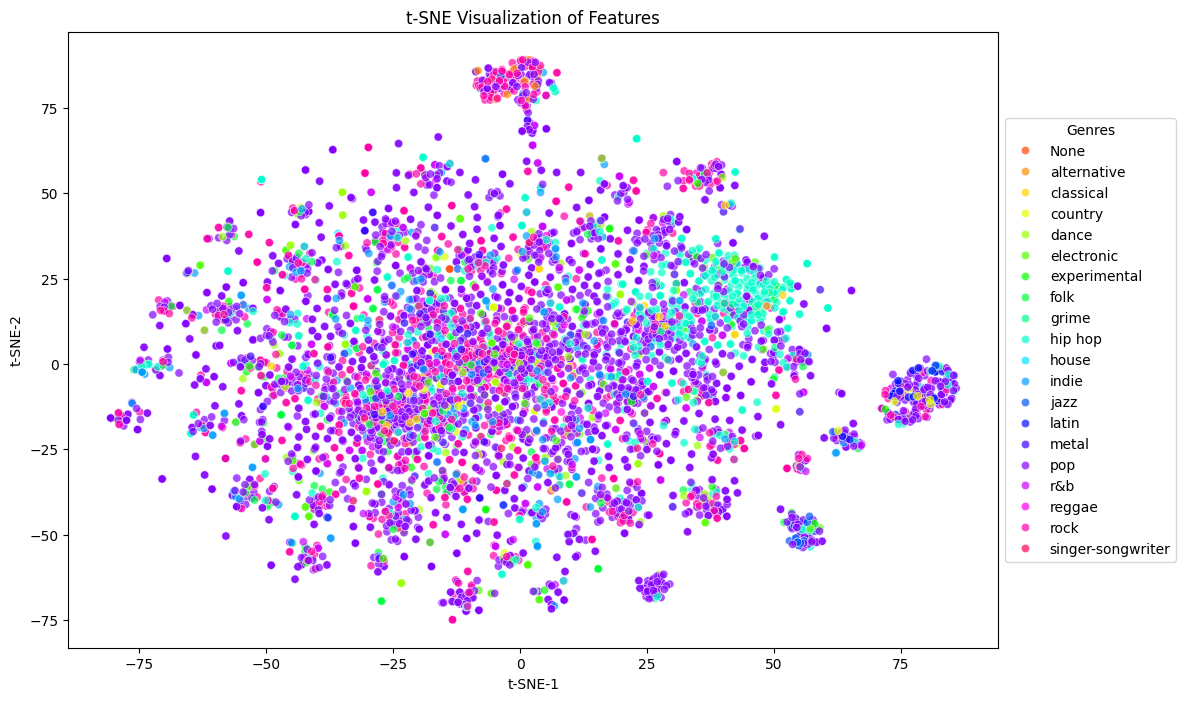

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

features = tfidf_features + lyrical_features + acoustic_features
# Features and labels
features = df[features].values  # Replace with your features
labels = df["genre"]  # Replace with your categorical variable

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(normalized_features)

# Add t-SNE results to the DataFrame
df["t-SNE-1"] = tsne_results[:, 0]
df["t-SNE-2"] = tsne_results[:, 1]

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="t-SNE-1", y="t-SNE-2", 
    hue=labels, 
    palette=sns.color_palette("hsv", len(df["genre"].unique())), 
    data=df,
    legend="full",
    alpha=0.7
)
plt.title("t-SNE Visualization of Features")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Genres")
plt.show()
